# Datasets (Sentiment) - Yelp - Categories

## Yelp

- https://www.yelp.com/dataset/documentation/main
- https://www.yelp.com/developers/documentation/v3/all_category_list

In [ ]:
#! wget -O data/sentiment/yelp/all_category_list.json https://www.yelp.com/developers/documentation/v3/all_category_list/categories.json

In [ ]:
#! pip install jsonlines

In [ ]:
#! pip install syntok

/disk1/users/ekoerner/miniconda3/envs/argmining19-ssc/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


[]

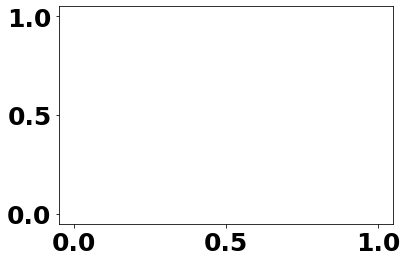

In [1]:
import json
import os
import random
import pickle
from collections import Counter
from copy import deepcopy
from itertools import combinations, groupby
from pathlib import Path
from pprint import pprint

import jsonlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.spatial.distance as ssd
from IPython.display import set_matplotlib_formats
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from syntok.tokenizer import Tokenizer
from tqdm import tqdm

tqdm.pandas()

%matplotlib inline
plt.rcParams.update({"font.size": 25, "font.weight": "bold"})
# https://stackoverflow.com/questions/36622237/jupyter-notebook-inline-plots-as-svg
# set_matplotlib_formats("svg")  # glitches it
plt.plot()

In [2]:
from utils_data import init_random
init_random()

In [3]:
# download + scp to cuda + extract
# Path on CUDA2
data_yelp_path = Path("/disk1/users/ekoerner/argmining19-same-side-classification/data/sentiment/yelp/")
# CUDA1?
#data_yelp_path = Path("/disk1/users/ekoerner/same-side-classification/argmining19-same-side-classification/data/sentiment/yelp/")

---

#### Load reviews / categories (topics) + filter cats/make combinations

In [4]:
def load_reviews(fn_yelp_reviews):
    """Load Yelp reviews. Return a Pandas dataframe.
    Format: {"id": business_id, "rid": review_id, "text": text, "rating": rating}
    And add goodness bool (rating > 3)."""
    data = list()

    with jsonlines.open(fn_yelp_reviews, "r") as fp:
        for n, entry in enumerate(tqdm(fp)):
            # print(entry)
            # break
            business_id = entry.pop("business_id")
            review_id = entry.pop("review_id")
            text = entry.pop("text", "")
            rating = entry.pop("stars", 0.0)
            data.append({"id": business_id, "rid": review_id, "text": text, "rating": rating})
            # TESTING
            # if n > 10000:
            #     break

    df = pd.DataFrame.from_dict(data)
    
    # Add goodness value
    # TODO: maybe ignore with 3
    df["goodness"] = df["rating"] > 3
    
    return df


def load_topics(fn_yelp_topics, bids_not_cats=None, filter_cats=None, filter_cat_combis=None):
    """Load topics (categories).
    Optionally filter by giving it a whitelist of allowed categories.
    Optionally filter by giving a list of allowed category combinations.
    Optionally provide an IN/OUT param ``bids_not_cats`` that accumulates business ids without categories."""
    inv_bid_cats = dict()
    if bids_not_cats is None or not isinstance(bids_not_cats, set):
        bids_not_cats = set()
    
    # load lookup business -> categories
    with jsonlines.open(fn_yelp_topics, "r") as fp:
        for n, entry in enumerate(tqdm(fp)):
            business_id = entry.pop("business_id")
            categories = entry.pop("categories")

            if not categories:
                bids_not_cats.add(business_id)
                continue

            categories = categories.split(", ")
            
            if filter_cats:
                categories = [c for c in categories if c in filter_cats]
                if not categories:
                    # bids_not_cats.add(business_id)  # ??
                    continue
                    
            if filter_cat_combis:
                # skip if combination is not above threshold (of filter list)
                if tuple(sorted(set(categories))) not in filter_cat_combis:
                    continue

            inv_bid_cats[business_id] = categories
    
    return inv_bid_cats

In [5]:
def filter_min_cat_combis(inv_cat_combis, min_num=30):
    """Filter category combinations by minimum amount of occurrences in businesses"""
    f_inv_cat_combis = dict()
    
    for cats, num in inv_cat_combis.items():
        if num >= min_num:
            f_inv_cat_combis[cats] = num
    
    return f_inv_cat_combis


def make_map_cats(inv_bid_cats):
    """Make a map from category to business id"""
    inv_cat_bids = dict()

    # reverse lookup: category -> businesses
    for bid, cats in tqdm(inv_bid_cats.items()):
        for cat in cats:
            try:
                inv_cat_bids[cat].append(bid)
            except KeyError:
                inv_cat_bids[cat] = [bid]
                
    ## TODO: make distinct?
    for cat in inv_cat_bids.keys():
        inv_cat_bids[cat] = list(set(inv_cat_bids[cat]))
                
    return inv_cat_bids


def make_cat_combis(inv_bid_cats):
    """Count amount of each category combination occurring in businesses"""
    inv_cat_combis = Counter()

    inv_cat_combis.update(
        (tuple(sorted(set(cats))) for cats in tqdm(inv_bid_cats.values())))
    
    return inv_cat_combis

#### Filter reviews according to criteria

In [6]:
def filter_min_review_freq(df, min_ratings=5):
    """Filter review dataframe for a minimum of N of each good and bad ratings."""
    # filter with at least N ratings per goodness
    df_filter = df.groupby(["id", "goodness"])[["id"]].count() < min_ratings
    df_filter = df_filter.rename(columns={"id": "filter"})
    df_filter = df_filter[df_filter["filter"] == True]

    # build a filter id list
    df_filter_list = df_filter.reset_index()["id"].to_list()

    # filter with list
    df_filtered = df[~df.id.isin(df_filter_list)]
    
    return df_filtered


def filter_both_good_bad(df):
    """Filter the dataframe to contain only both good and bad reviews for each business.
    Dataframe should be the same if minimum filtering above is done."""
    # build filter for ids that contain both positive and negative samples
    df_filter = df.groupby(["id", "goodness"], as_index=False).count().groupby("id")[["id"]].count() == 2
    df_filter = df_filter.rename(columns={"id": "filter"})
    df_filter = df_filter[df_filter["filter"] == True]

    # create list of IDs for which this is true
    df_filter_list = df_filter.reset_index()["id"].to_list()

    # filter with list
    df_filtered = df[df.id.isin(df_filter_list)]

    # df_filtered.groupby(["id", "goodness"]).count()
    return df_filtered

In [7]:
def filter_by_businesses(df, lst_business_ids):
    # filter with list, keep businesses in list
    df_filtered = df[df.id.isin(set(lst_business_ids))]

    return df_filtered


def filter_by_businesses_not_same(df, lst_business_ids):
    # filter with list, keep businesses that are not in list
    df_filtered = df[~df.id.isin(set(lst_business_ids))]

    return df_filtered

#### Get topN categories + make Ntuples from category combinations

In [8]:
def get_Ntop_cats(inv_cat_bids, n=50):
    # get most common cats
    f_cat_cnt = Counter({k: len(v) for k, v in inv_cat_bids.items()})
    f_cats = {c for c, v in f_cat_cnt.most_common(n)}
    return f_cats


def make_cat_Ntuples(f_inv_cat_combis, n=2):
    f_cat_pairs = Counter()

    for cat_group in tqdm(f_inv_cat_combis.keys()):
        if len(cat_group) < n:
            continue
        it = combinations(cat_group, n)
        # repeat (#num_businesses) + chain combis
        f_cat_pairs.update(it)
        
    return f_cat_pairs

#### Make category graph or NxN map (df + array)

In [9]:
def make_graph(f_cat_pairs):
    g_from, g_to, g_value = zip(*((k1, k2, n) for (k1, k2), n in tqdm(f_cat_pairs.most_common())))

    g_df = pd.DataFrame({"from": g_from, "to": g_to, "value": g_value})
    G = nx.from_pandas_edgelist(g_df, "from", "to", create_using=nx.Graph())
    
    return G


def make_NxN_map(f_cats, f_cat_pairs):
    f_cats = list(f_cats)
    array = list()
    for i, cat1 in enumerate(tqdm(f_cats)):
        array_row = list()
        for j, cat2 in enumerate(f_cats):
            array_row.append(f_cat_pairs.get((cat1, cat2), f_cat_pairs.get((cat2, cat1), 0)))
        array.append(array_row)
    df_cm = pd.DataFrame(array, index=list(f_cats), columns=list(f_cats))
    
    # dataframe, NxN array + labels
    return df_cm, array, f_cats

---

#### Load categories hierarchy

In [10]:
def load_category_tree(fn_all_category_list):
    with open(fn_all_category_list, "r") as fp:
        content = fp.read()
        data = json.loads(content)

    map_categories = dict()
    map_cat_name2id = dict()
    lst_root_categories = list()

    # load basic lookups
    for item in data:
        # .alias (id)
        map_categories[item["alias"]] = item
        # .title
        map_cat_name2id[item["title"]] = item["alias"]
        # .parents
        # some have multiple parents ...
        if not item["parents"]:
            lst_root_categories.append(item["alias"])
        # add list of children
        item["children"] = list()

    # add children
    for cid, item in map_categories.items():
        for parent_cid in item["parents"]:
            map_categories[parent_cid]["children"].append(item["alias"])

    return map_categories, map_cat_name2id, lst_root_categories


def get_root_category_items(map_categories):
    lst_root_categories = list()

    for cid, item in map_categories.items():
        if not item["parents"]:
            lst_root_categories.append(item)
            
    return lst_root_categories


def get_children_category_item_list(map_categories, parent_cid):
    return [
        map_categories[child_cid]
        for child_cid in map_categories[parent_cid]["children"]
    ]

##### Get businesses in categories

In [11]:
def get_businesses_in_category(inv_cat_bids, category):
    try:
        return list(set(inv_cat_bids[category]))
    except KeyError:
        return []
    
    
def get_businesses_in_category_branch(inv_cat_bids, category, map_categories, map_cat_name2id):
    map_cat_id2name = {cid: name for name, cid in map_cat_name2id.items()}

    def _get_recursive_businesses(cat_name):
        businesses = get_businesses_in_category(inv_cat_bids, cat_name)

        cid = map_cat_name2id[cat_name]
        for child_cid in map_categories[cid]["children"]:
            child_name = map_cat_id2name[child_cid]
            businesses.extend(_get_recursive_businesses(child_name))
        
        return businesses
    
    return _get_recursive_businesses(category)

##### Print category trees

In [12]:
def print_category_tree(map_categories):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            if level:
                print("  " * level, end="")
            print(f"""{item["title"]} [{item["alias"]}]""", end="")
            if item["children"]:
                print(f""" [#{len(item["children"])} children]""")
            else:
                print()
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
    _print_cat_list_rec(root_categories, level=0)


def print_category_tree_with_num_businesses(map_categories, inv_cat_bids):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            cur_line = " ." * 30
            parts = list()

            if level:
                parts.append("  " * level)
            parts.append(f"""{item["title"]} [{item["alias"]}]""")
            
            str_len = sum(len(part) for part in parts)
            print("".join(part for part in parts), end="")
            print(cur_line[str_len:], end="")
            
            if item["title"] not in inv_cat_bids:
                print(" No businesses associated!")
            else:
                print(f""" {len((inv_cat_bids[item["title"]])):>5d} businesses""")
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
            if level == 0:
                print()
            
    _print_cat_list_rec(root_categories, level=0)
    

def print_category_tree_with_num_businesses_rec(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            cur_line = " ." * 30
            parts = list()

            if level:
                parts.append("  " * level)
            parts.append(f"""{item["title"]} [{item["alias"]}]""")
            
            str_len = sum(len(part) for part in parts)
            print("".join(part for part in parts), end="")
            print(cur_line[str_len:], end="")
            
            businesses = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
            businesses_self = get_businesses_in_category(inv_cat_bids, item["title"])
            if not businesses:
                print(" No businesses associated!")
            else:
                businesses = set(businesses)
                print(f""" {len(businesses):>5d} businesses""", end="")
                if len(businesses) != len(businesses_self):
                    print(f""" (self: {len(businesses_self)})""", end="")
                print()
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
            if level == 0:
                print()
            
    _print_cat_list_rec(root_categories, level=0)
    
    
def print_category_tree_with_num_businesses_root(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    
    for item in sorted(root_categories, key=lambda x: x["title"]):
        cur_line = " ." * 25
        parts = [f"""{item["title"]} [{item["alias"]}] """]

        str_len = sum(len(part) for part in parts)
        print("".join(part for part in parts), end="")
        print(cur_line[str_len:], end="")

        businesses = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
        businesses_self = get_businesses_in_category(inv_cat_bids, item["title"])

        businesses = set(businesses)
        print(f""" {len(businesses):>5d} businesses""", end="")
        if len(businesses) != len(businesses_self):
            print(f""" (self: {len(businesses_self)})""", end="")
        print()
        

def print_category_tree_with_num_businesses_root2(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    for item in root_categories:
        item["businesses"] = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
        item["businesses_self"] = get_businesses_in_category(inv_cat_bids, item["title"])
    
    for item in sorted(root_categories, key=lambda x: len(set(x["businesses"]))):
        cur_line = " ." * 25
        parts = [f"""{item["title"]} [{item["alias"]}] """]

        str_len = sum(len(part) for part in parts)
        print("".join(part for part in parts), end="")
        print(cur_line[str_len:], end="")

        businesses = item["businesses"]
        businesses_self = item["businesses_self"]

        businesses = set(businesses)
        print(f""" {len(businesses):>5d} businesses""", end="")
        if len(businesses) != len(businesses_self):
            print(f""" (self: {len(businesses_self)})""", end="")
        print()

In [13]:
def print_category_tree_with_num_reviews_root(map_categories, inv_cat_bids, map_cat_name2id, df_reviews):
    root_categories = get_root_category_items(map_categories)
    
    for item in sorted(root_categories, key=lambda x: x["title"]):
        cur_line = " ." * 25
        parts = [f"""{item["title"]} [{item["alias"]}] """]

        str_len = sum(len(part) for part in parts)
        print("".join(part for part in parts), end="")
        print(cur_line[str_len:], end="")

        businesses = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
        # businesses_self = get_businesses_in_category(inv_cat_bids, item["title"])
        
        df_reviews_filtered = filter_by_businesses(df_reviews, businesses)
        num_reviews = df_reviews_filtered.rid.count()

        print(f""" {num_reviews:>8d} reviews""")

##### Make category comparisons

In [14]:
def print_2category_compare(inv_cat_bids, map_categories, map_cat_name2id, cat_name_i, cat_name_j):
    businesses_i = get_businesses_in_category_branch(inv_cat_bids, cat_name_i, map_categories, map_cat_name2id)
    businesses_j = get_businesses_in_category_branch(inv_cat_bids, cat_name_j, map_categories, map_cat_name2id)
    
    cat_name_i += ":"
    cat_name_j += ":"
    width = max(12, len(cat_name_i), len(cat_name_j))

    print(f"""{cat_name_i:<{width}} {len(set(businesses_i)):>5d}""")
    print(f"""{cat_name_j:<{width}} {len(set(businesses_j)):>5d}""")
    print(f"""Both: {"same:":>{width - 6}} {len(set(businesses_i) & set(businesses_j)):>5d}""")
    print(f"""{"total:":>{width}} {len(set(businesses_i) | set(businesses_j)):>5d}""")

In [15]:
def make_NxN_category_businesses_overlap(inv_cat_bids, map_categories, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    root_categories = sorted(root_categories, key=lambda x: x["title"])
    root_category_labels = [x["title"] for x in root_categories]
    
    array = list()
    for cname_i in root_category_labels:
        array_line = list()
        for cname_j in root_category_labels:
            businesses_i = get_businesses_in_category_branch(inv_cat_bids, cname_i, map_categories, map_cat_name2id)
            businesses_j = get_businesses_in_category_branch(inv_cat_bids, cname_j, map_categories, map_cat_name2id)
            businesses_i, businesses_j = set(businesses_i), set(businesses_j)
            businesses_ij_union = businesses_i | businesses_j
            businesses_ij_intersect = businesses_i & businesses_j
            num_businesses_ij = len(businesses_ij_intersect)
            #array_line.append(num_businesses_ij)
            array_line.append(len(businesses_ij_intersect) / len(businesses_ij_union))
        array.append(array_line)
    
    df_cm = pd.DataFrame(array, index=list(root_category_labels), columns=list(root_category_labels))
    
    return array, root_category_labels, df_cm

##### text length comparisons?

In [16]:
def get_reviews_for_category(df, cat_name, inv_cat_bids, map_categories, map_cat_name2id):
    businesses = get_businesses_in_category_branch(inv_cat_bids, cat_name, map_categories, map_cat_name2id)
    print(f"""{cat_name}: {len(businesses)}, uniq: {len(set(businesses))}""")
    businesses = set(businesses)

    df_businesses = filter_by_businesses(df, businesses)

    return df_businesses

##### Cache root category reviews in dataframes

In [17]:
dn_yelp_cached = data_yelp_path / "cached"


def cache_root_category_businesses_df(df, inv_cat_bids, map_categories, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    root_categories = sorted(root_categories, key=lambda x: x["title"])
    
    dn_yelp_cached = data_yelp_path / "cached"
    if not dn_yelp_cached.exists():
        print(f"Create cache dir: {dn_yelp_cached}")
        dn_yelp_cached.mkdir()
        
    for root_category in root_categories:
        fn_yelp_cached_root_cat_df = dn_yelp_cached / f"""{root_category["alias"]}_businesses.df.p"""
        if fn_yelp_cached_root_cat_df.exists():
            continue

        business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
        # business_ids = set(root_category["businesses"])
        print(f"""Filter category {root_category["title"]} [{root_category["alias"]}] with {len(set(business_ids))} businesses ...""")
        df_root_cat = filter_by_businesses(df, business_ids)

        # df_root_cat = get_reviews_for_category(df, cat_name, inv_cat_bids, map_categories, map_cat_name2id)

        df_root_cat.to_pickle(str(fn_yelp_cached_root_cat_df))
        
        
def load_cached_root_category_businesses_df(category_label, map_categories):
    root_categories = get_root_category_items(map_categories)
    root_categories = sorted(root_categories, key=lambda x: x["title"])

    for root_category in root_categories:
        if root_category["title"] == category_label:
            category_id = root_category["alias"]
            break
    else:
        print(f"No cached root category businesses found for: {category_label}")
        return None

    fn_yelp_cached_root_cat_df = dn_yelp_cached / f"{category_id}_businesses.df.p"
    if not fn_yelp_cached_root_cat_df.exists():
        return None
    
    df_root_cat = pd.read_pickle(str(fn_yelp_cached_root_cat_df))
    return df_root_cat

##### Filter other category businesses

In [18]:
def filter_root_category_businesses_uniq(category_label, inv_cat_bids, map_categories, map_cat_name2id):
    df_root_cat = load_cached_root_category_businesses_df(category_label, map_categories)
    
    root_categories = get_root_category_items(map_categories)
    # root_categories = sorted(root_categories, key=lambda x: len(x["businesses"]), reverse=False)
    
    for root_category in root_categories:
        if root_category["title"] == category_label:
            # skip, do not trim self
            continue
            
        business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
        # business_ids = set(root_category["businesses"])
        print(f"""Filter businesses from category {root_category["title"]} [{root_category["alias"]}] ({len(business_ids)} businesses) ...""")
        n_before = len(df_root_cat)
        df_root_cat = filter_by_businesses_not_same(df_root_cat, business_ids)
        n_after = len(df_root_cat)
        print(f"""Filtered {n_before - n_after} businesses (overlap with {root_category["title"]})""")
        
    return df_root_cat

In [19]:
def filter_root_category_businesses_not_other(category_label, category_label_filter, inv_cat_bids, map_categories, map_cat_name2id):
    assert category_label != category_label_filter, "do not filter on self"

    df_root_cat = load_cached_root_category_businesses_df(category_label, map_categories)
    
    root_categories = get_root_category_items(map_categories)
    # root_categories = sorted(root_categories, key=lambda x: len(x["businesses"]), reverse=True)
    
    for root_category in root_categories:
        if root_category["title"] == category_label_filter:
            break
    else:
        print(f"No businesses found for {category_label_filter} -> return unchanged")
        return df_root_cat
    
    business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
    # businesses_ids = root_category["businesses"]
    print(f"""Filter businesses from category {root_category["title"]} [{root_category["alias"]}] ({len(set(business_ids))} businesses) ...""")
    n_before = len(df_root_cat)
    df_root_cat = filter_by_businesses_not_same(df_root_cat, business_ids)
    n_after = len(df_root_cat)
    print(f"""Filtered {n_before - n_after} businesses (overlap with {root_category["title"]})""")
    
    return df_root_cat

In [20]:
def filter_root_category_businesses_same_other(category_label, category_label_filter, inv_cat_bids, map_categories, map_cat_name2id):
    assert category_label != category_label_filter, "do not filter on self"

    df_root_cat = load_cached_root_category_businesses_df(category_label, map_categories)
    
    root_categories = get_root_category_items(map_categories)
    # root_categories = sorted(root_categories, key=lambda x: len(x["businesses"]), reverse=True)
    
    for root_category in root_categories:
        if root_category["title"] == category_label_filter:
            break
    else:
        print(f"No businesses found for {category_label_filter} -> return unchanged")
        return df_root_cat
    
    business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
    # businesses_ids = root_category["businesses"]
    print(f"""Filter businesses from category {root_category["title"]} [{root_category["alias"]}] ({len(set(business_ids))} businesses) ...""")
    n_before = len(df_root_cat)
    df_same = filter_by_businesses(df_root_cat, business_ids)
    n_after = len(df_same)
    print(f"""Filtered {n_before - n_after} businesses ({n_after} same with {root_category["title"]})""")
    
    return df_same

---

#### Make Pairs

**TODO:**

- check similar length -- what strategy to use to combine similar length pairs best?
- flip sides (arg1 <-> arg2)
- make more pairs (?) -- but keep same ratio of same-sentiment vs. not-same-sentiment (different-sentiment) ??
- group by categories (topics) -- more explicit training (uniqueness of single arguments / topic structures)
- evaluate on same-argument (S3C) - or amazon reviews
- compute mean/avg sequence length
- fixed layers in fine-tuning
- visualization of trained layers and activation for good / bad inputs

##### Positive + negative same-sentiment pairs

In [21]:
num_pairs_per_class = 2
# N positive + N negative
# --> 2N pos+neg (not same-sentiment)

# TODO: randomness for positive ss / negative ss - sum is equal / or sum equal compared to not ss

In [22]:
def make_pairs_good_bad(df, num_pairs_per_class=2):
    pairs_good = list()
    pairs_bad = list()

    for id_, group in tqdm(df.groupby("id")):
        grouper = group.groupby("goodness")
        reviews_good = grouper.get_group(True)
        reviews_bad = grouper.get_group(False)

        # TESTING
        # print("id:", id_)
        # print("#good:", len(reviews_good))
        # print("#bad:", len(reviews_bad))
        # print(group)
        # break

        # make pairings -- good ss
        rg_idx = reviews_good.index.values
        # print("pos_idx:", rg_idx)
        rg_idx_sel = np.random.choice(rg_idx, 2 * num_pairs_per_class, replace=False)
        for id1, id2 in zip(rg_idx_sel[::2], rg_idx_sel[1::2]):
            # print("pair:", id1, id2)
            r1, r2 = df.loc[id1], df.loc[id2]
            pair = {
                "argument1": r1["text"], "argument2": r2["text"],
                "argument1_id": f"""{r1["id"]}|{r1["rid"]}""", "argument2_id": f"""{r2["id"]}|{r2["rid"]}""",
                "is_same_side": True, "is_good_side": True,
                "topic": inv_bid_cats.get(r1["id"], None)
            }
            # print(pair)
            pairs_good.append(pair)

        # make pairings -- bad ss
        rb_idx = reviews_bad.index.values
        # print("neg_idx:", rb_idx)
        rb_idx_sel = np.random.choice(rb_idx, 2 * num_pairs_per_class, replace=False)
        for id1, id2 in zip(rb_idx_sel[::2], rb_idx_sel[1::2]):
            r1, r2 = df.loc[id1], df.loc[id2]
            pair = {
                "argument1": r1["text"], "argument2": r2["text"],
                "argument1_id": f"""{r1["id"]}|{r1["rid"]}""", "argument2_id": f"""{r2["id"]}|{r2["rid"]}""",
                "is_same_side": True, "is_good_side": False,
                "topic": inv_bid_cats.get(r1["id"], None)
            }
            pairs_bad.append(pair)

        # break
        
    return pairs_good, pairs_bad

##### not same-sentiment pairs (combinations positive + negative)

In [23]:
#: number of negative same-sentiment samples same as positive same-sentiment samples
num_pairs_negative = 2 * num_pairs_per_class

#: whether for a single side (good or bad) there can be multiple occurrences of the same review
#: may need to check afterwared that not by chance same pairing happens ...
repeatable_on_side = False

In [24]:
def make_pairs_negative(df, num_pairs_negative, repeatable_on_side=False):
    pairs_not_ss = list()

    for id_, group in tqdm(df.groupby("id")):
        grouper = group.groupby("goodness")
        reviews_good = grouper.get_group(True)
        reviews_bad = grouper.get_group(False)

        # find indices for reviews per business
        rg_idx = reviews_good.index.values
        rb_idx = reviews_bad.index.values

        # randomly select from each side
        rg_idx_sel = np.random.choice(rg_idx, num_pairs_negative, replace=repeatable_on_side)
        rb_idx_sel = np.random.choice(rb_idx, num_pairs_negative, replace=repeatable_on_side)

        # pair them together -- good-bad pairs
        for idg, idb in zip(rg_idx_sel[::2], rb_idx_sel[::2]):
            rg, rb = df.loc[idg], df.loc[idb]
            pair = {
                "argument1": rg["text"], "argument2": rb["text"],
                "argument1_id": f"""{rg["id"]}|{rg["rid"]}""", "argument2_id": f"""{rb["id"]}|{rb["rid"]}""",
                "is_same_side": False, "is_good_side": None,
                "topic": inv_bid_cats.get(rg["id"], None)
            }
            # print(pair)
            pairs_not_ss.append(pair)

        # bad-good pairs
        for idb, idg in zip(rb_idx_sel[1::2], rg_idx_sel[1::2]):
            rb, rg = df.loc[idb], df.loc[idg]
            pair = {
                "argument1": rb["text"], "argument2": rg["text"],
                "argument1_id": f"""{rb["id"]}|{rb["rid"]}""", "argument2_id": f"""{rg["id"]}|{rg["rid"]}""",
                "is_same_side": False, "is_good_side": None,
                "topic": inv_bid_cats.get(rb["id"], None)
            }
            # print(pair)
            pairs_not_ss.append(pair)
            
    return pairs_not_ss

##### dataframe for training etc.

In [25]:
def make_or_load_pairs(df, fn_yelp_df, num_pairs_per_class=2):
    if fn_yelp_df is not None:
        if os.path.exists(fn_yelp_df):
            with open(fn_yelp_df, "rb") as fp:
                all_df = pickle.load(fp)
            return all_df
    
    pairs_good, pairs_bad = make_pairs_good_bad(df, num_pairs_per_class=num_pairs_per_class)
    print("#ss (pos)", len(pairs_good))
    print("#ss (neg)", len(pairs_bad))
    
    num_pairs_negative = 2 * num_pairs_per_class
    pairs_not_ss = make_pairs_negative(df, num_pairs_negative, repeatable_on_side=False)
    print("#nss", len(pairs_not_ss))
    
    pairs_all = pairs_good + pairs_bad + pairs_not_ss
    print("#~ss", len(pairs_all))
    
    np.random.shuffle(pairs_all)
    df_traindev = pd.DataFrame.from_dict(pairs_all)
    
    if fn_yelp_df is not None:
        with open(fn_yelp_df, "wb") as fp:
            pickle.dump(df_traindev, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
    return df_traindev

---

---

---

## Load reviews and topics and category tree

#### Load reviews

- review (with business reference)

In [26]:
fn_yelp_reviews = data_yelp_path / "review.json"
df = load_reviews(fn_yelp_reviews)

6685900it [00:41, 161907.41it/s]


In [27]:
#businesses = get_businesses_in_category_branch(inv_cat_bids, "Mass Media", map_categories, map_cat_name2id)
#filter_by_businesses(df, businesses).rid.count()

#### Load categories for businesses

- business (id) with list of topics/categories
- lookups (business -> categories, category -> businesses)
- list of combinations (with amount)

In [28]:
fn_yelp_topics = data_yelp_path / "business.json"
bids_not_cats = set()
inv_bid_cats = load_topics(fn_yelp_topics, bids_not_cats=bids_not_cats)

inv_cat_bids = make_map_cats(inv_bid_cats)

inv_cat_combis = make_cat_combis(inv_bid_cats)

192609it [00:02, 69284.19it/s]
100%|██████████| 192127/192127 [00:00<00:00, 495753.29it/s]


#### Load category tree

- hierarchy of categories

In [29]:
fn_yelp_catgory_tree = data_yelp_path / "all_category_list.json"
map_categories, map_cat_name2id, lst_root_categories = load_category_tree(fn_yelp_catgory_tree)

#### Pre-Cache all root category businesses (reviews)

In [30]:
cache_root_category_businesses_df(df, inv_cat_bids, map_categories, map_cat_name2id)

---

In [31]:
# number of businesses
print(f"Number of businesses total: {len(inv_bid_cats.keys())}")
# number of reviews (total)
print(f"Number of reviews total: {df.rid.count()}")

Number of businesses total: 192127
Number of reviews total: 6685900


In [ ]:
# Number of words:
tok = Tokenizer()

def tokenize_text(row):
    row["text_tok"] = [str(tok) for tok in tok.tokenize(row["text"])]
    return row

def count_words(row):
    row["num_words"] = len(row["text_tok"])
    return row

df = filter_min_review_freq(df, min_ratings=5)
df = df.progress_apply(tokenize_text, axis=1)
df = df.progress_apply(count_words, axis=1)
print(f"""all*: {df["num_words"].mean()}""")

In [ ]:
df["num_words"].describe()

```python
count    5.756784e+06
mean     1.289253e+02
std      1.218024e+02
min      1.000000e+00
25%      5.000000e+01
50%      9.100000e+01
75%      1.640000e+02
max      1.870000e+03
Name: num_words, dtype: float64
```

In [32]:
fn_df_words = data_yelp_path / "df_reviews_words.p"

In [ ]:
with open(fn_df_words, "wb") as fp:
    pickle.dump(df, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
with open(fn_df_words, "rb") as fp:
    df = pickle.load(fp)

---

### Filter business without any overlap

In [34]:
# build lookup of category -> business_ids
lookup_rootcat_bid = dict()

# --> print_category_tree_with_num_businesses_root(map_categories, inv_cat_bids, map_cat_name2id)
root_categories = get_root_category_items(map_categories)

for item in sorted(root_categories, key=lambda x: x["title"]):
    businesses = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
    businesses = set(businesses)
    lookup_rootcat_bid[(item["title"], item["alias"])] = businesses

In [35]:
# remove duplicates / overlapping businesses
lookup_rootcat_bid_no_overlap = dict()

for (title, alias), businesses in lookup_rootcat_bid.items():
    # collect business ids from other categories
    businesses_other = set()
    for (title2, alias2), businesses2 in lookup_rootcat_bid.items():
        if alias2 == alias:
            continue
        businesses_other |= businesses2

    # remove other businesses
    businesses_no_overlap = businesses - businesses_other

    lookup_rootcat_bid_no_overlap[(title, alias)] = businesses_no_overlap

In [36]:
print("category | businesses | businesses_no_overlap_to_any_other")
for ((title, alias), businesses), business_no_overlap in zip(lookup_rootcat_bid.items(), lookup_rootcat_bid_no_overlap.values()):
    print(f"{title}[{alias}] | {len(businesses)}  {len(business_no_overlap)}")

category | businesses | businesses_no_overlap_to_any_other
Active Life[active] | 9521  4533
Arts & Entertainment[arts] | 6304  1225
Automotive[auto] | 13203  9755
Beauty & Spas[beautysvc] | 19370  12931
Bicycles[bicycles] | 9  0
Education[education] | 3314  831
Event Planning & Services[eventservices] | 10371  1456
Financial Services[financialservices] | 3082  1749
Food[food] | 29989  10418
Health & Medical[health] | 17171  10767
Home Services[homeservices] | 19744  11131
Hotels & Travel[hotelstravel] | 6033  1725
Local Flavor[localflavor] | 1444  120
Local Services[localservices] | 13932  4244
Mass Media[massmedia] | 319  142
Nightlife[nightlife] | 13095  2342
Pets[pets] | 4111  3470
Professional Services[professional] | 6276  1514
Public Services & Government[publicservicesgovt] | 1343  628
Religious Organizations[religiousorgs] | 547  386
Restaurants[restaurants] | 59371  35639
Shopping[shopping] | 31878  14871


In [37]:
print(f"Number businesses all (overlapping): {sum(len(bs) for bs in lookup_rootcat_bid.values())}")
print(f"Number businesses all (no overlap): {sum(len(bs) for bs in lookup_rootcat_bid_no_overlap.values())}")

Number businesses all (overlapping): 270427
Number businesses all (no overlap): 129877


### Filter from pair df

In [38]:
# load data with more pairs
fn_yelp_df = data_yelp_path / "df_traindev4_typed.p"

with open(fn_yelp_df, "rb") as fp:
    traindev_df = pickle.load(fp)

In [39]:
def add_business_id(row):
    bid = row["argument1_id"].split("|")[0]
    row["business_id"] = bid
    return row

traindev_df = traindev_df.progress_apply(add_business_id, axis=1)

100%|██████████| 703760/703760 [07:00<00:00, 1672.94it/s] 


In [40]:
# filter no overlapping business
all_business_ids_no_overlap = set()
for businesses in lookup_rootcat_bid_no_overlap.values():
    all_business_ids_no_overlap |= businesses

traindev_df = traindev_df[traindev_df.business_id.isin(all_business_ids_no_overlap)]

In [43]:
# manual root category group splitting
cats = list(lookup_rootcat_bid_no_overlap.keys())
cats.remove(('Bicycles', 'bicycles'))

# make it repeatable
from utils_data import init_random
init_random()

np.random.shuffle(cats)
groups = cats[0:3], cats[3:6], cats[6:9], cats[9:12], cats[12:15], cats[15:18], cats[18:21]
groups = [tuple(g) for g in groups]

# filter business ids of group
map_cg_bids = dict()
for cg_ids in groups:
    cg_businesses = set()
    for ta_id, businesses in lookup_rootcat_bid_no_overlap.items():
        if ta_id in cg_ids:
            cg_businesses |= businesses
    
    map_cg_bids[cg_ids] = cg_businesses

In [44]:
# build dataframes for each group
map_cg_traindev_df = dict()

for cg_ids in groups:
    businesses = map_cg_bids[cg_ids]
    cg_df = traindev_df[traindev_df.business_id.isin(businesses)]
    map_cg_traindev_df[cg_ids] = cg_df

In [45]:
# make cross eval split traindev dfs
map_cg_train_dev_groups = dict()

for cg_ids, cg_df in map_cg_traindev_df.items():
    train_df = cg_df
    dev_dfs = [
        cg_df_o
        for cg_ids_o, cg_df_o in map_cg_traindev_df.items()
        if cg_ids_o != cg_ids
    ]
    dev_df = pd.concat(dev_dfs)
    map_cg_train_dev_groups[cg_ids] = (train_df, dev_df, dev_dfs)

In [46]:
fn_group = data_yelp_path / "group_data_save_k=7.p"

with open(fn_group, "wb") as fp:
    pickle.dump(groups, fp, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(map_cg_train_dev_groups, fp, protocol=pickle.HIGHEST_PROTOCOL)

## Train groups  --  Default S3C training

https://gluon-nlp.mxnet.io/install.html

```bash
pip install --upgrade 'mxnet>=1.3.0'  
pip install gluonnlp  
wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip  
unzip sentence_embedding.zip  
ln -s sentence_embedding/bert bert  
```

In [ ]:
# ! pip install --upgrade 'mxnet>=1.3.0'
# NOTE: do not install cpu + gpu version both, only one!
#! pip install --upgrade mxnet-cu102
#! pip install --upgrade gluonnlp 

In [ ]:
#! wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip
# ! unzip sentence_embedding.zip
# ! ln -s sentence_embedding/bert bert

In [47]:
from mxboard import SummaryWriter

from utils_data import get_train_test_sets

from utils_gluon import setup_bert_epi128bce, setup_bert_epi512bce
from utils_gluon import setup_bert_pro128bce, setup_bert_pro512bce

from utils_gluon import transform_dataset
from utils_gluon import predict_out_to_ys

from utils_gluon import predict
from utils_gluon import train

# from utils_gluon import print_infos
from utils_gluon import plot_train_stats

from utils_gluon import report_training_results
from utils_gluon import plot_confusion_matrix
from utils_gluon import compute_metrics

from utils_data import names_columns_X, names_columns_X_arteval, names_columns_y
# names_columns_X = ['argument1', 'argument2', 'argument1_id', 'argument2_id', 'topic', 'type']
names_columns_X = names_columns_X + ["type", "business_id"]

In [48]:
from utils_data import Timer

from utils_data import configure_logging
configure_logging()

from utils_data import init_random
init_random()

In [49]:
run_name = "yelp_10_pro128BCE"
run_name_base = run_name
fn_run_path = Path(f"data/{run_name}")
if not fn_run_path.exists():
    fn_run_path.mkdir()

In [50]:
num_epochs = 5
batch_size = 32

epoch_id = num_epochs - 1

In [51]:
with Timer("setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert_pro128bce(gpu=1)

Start on [setup BERT model] ...
Time for [setup BERT model]: 0:00:11.461039


Train model on group fold (('Religious Organizations', 'religiousorgs'), ('Shopping', 'shopping'), ('Local Flavor', 'localflavor')) #22656...
Start on [prepare training / validation data] ...
Time for [prepare training / validation data]: 0:00:31.535461


  1%|          | 133/22656 [00:00<00:16, 1325.48it/s]

Start on [train model - 5] ...
Start on [setup training] ...


  0%|          | 0/714 [00:00<?, ?it/s]

Time for [setup training]: 0:00:12.912840
Start on [training] ...
Start on [epoch 0] ...


  0%|          | 1/714 [00:01<16:47,  1.41s/it]2020-07-13 11:43:28,956 : INFO : successfully opened events file: data/yelp_10_pro128BCE_g0/events.out.tfevents.1594633408.cuda2
2020-07-13 11:43:28,977 : INFO : wrote 1 event to disk
2020-07-13 11:43:28,978 : INFO : wrote 1 event to disk
 70%|███████   | 500/714 [02:07<00:55,  3.87it/s]

[Epoch 0 Batch 500/714] loss=0.6153, lr=0.0000050, acc=0.659 - time 0:02:07.858102


100%|██████████| 714/714 [03:02<00:00,  3.91it/s]


Time for [epoch 0]: 0:03:02.772741


  0%|          | 0/714 [00:00<?, ?it/s]

Start on [epoch 1] ...


 70%|███████   | 500/714 [02:09<00:55,  3.83it/s]

[Epoch 1 Batch 500/714] loss=0.5007, lr=0.0000050, acc=0.756 - time 0:02:09.742532


100%|██████████| 714/714 [03:04<00:00,  3.87it/s]


Time for [epoch 1]: 0:03:04.611010


  0%|          | 0/714 [00:00<?, ?it/s]

Start on [epoch 2] ...


 70%|███████   | 500/714 [02:10<00:55,  3.88it/s]

[Epoch 2 Batch 500/714] loss=0.4338, lr=0.0000050, acc=0.794 - time 0:02:10.115372


100%|██████████| 714/714 [03:04<00:00,  3.86it/s]


Time for [epoch 2]: 0:03:04.933982


  0%|          | 0/714 [00:00<?, ?it/s]

Start on [epoch 3] ...


 70%|███████   | 500/714 [02:09<00:56,  3.82it/s]

[Epoch 3 Batch 500/714] loss=0.3870, lr=0.0000050, acc=0.822 - time 0:02:09.699465


100%|██████████| 714/714 [03:04<00:00,  3.86it/s]


Time for [epoch 3]: 0:03:04.923995


  0%|          | 0/714 [00:00<?, ?it/s]

Start on [epoch 4] ...


 70%|███████   | 500/714 [02:09<00:47,  4.54it/s]

[Epoch 4 Batch 500/714] loss=0.3285, lr=0.0000050, acc=0.854 - time 0:02:09.329463


100%|██████████| 714/714 [03:05<00:00,  3.86it/s]


Time for [epoch 4]: 0:03:05.134997
Time for [training]: 0:15:24.129656


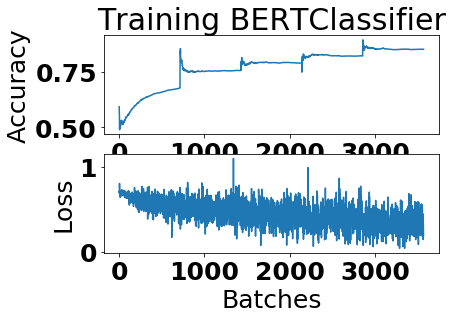

2020-07-13 11:58:51,842 : INFO : wrote 2481 events to disk
  0%|          | 0/12654 [00:00<?, ?it/s]

Time for [train model - 5]: 0:15:37.220079
Start on [evaluate model - 5] ...
Start on [prediction] ...


  0%|          | 1/12654 [00:00<35:56,  5.87it/s]2020-07-13 11:58:52,021 : INFO : successfully opened events file: data/yelp_10_pro128BCE_g0/events.out.tfevents.1594634332.cuda2
2020-07-13 11:58:52,038 : INFO : wrote 1 event to disk
2020-07-13 11:58:52,039 : INFO : wrote 1 event to disk
100%|██████████| 12654/12654 [20:17<00:00, 10.39it/s]


Time for [prediction]: 0:20:17.487284
Accuracy in epoch 4: 0.7571494191559981
Confusion Matrix:
[[153156  49308]
 [ 49029 153435]]

CM: [153156  49308  49029 153435] 
[tn, fp, fn, tp]
  accuracy: 0.757
 precision: 0.757
    recall: 0.757
  f1-score: 0.757

Accuracy:  0.757 

Report for [BERTClassifier - yelp_10_pro128BCE_g0]:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76    202464
           1       0.76      0.76      0.76    202464

    accuracy                           0.76    404928
   macro avg       0.76      0.76      0.76    404928
weighted avg       0.76      0.76      0.76    404928



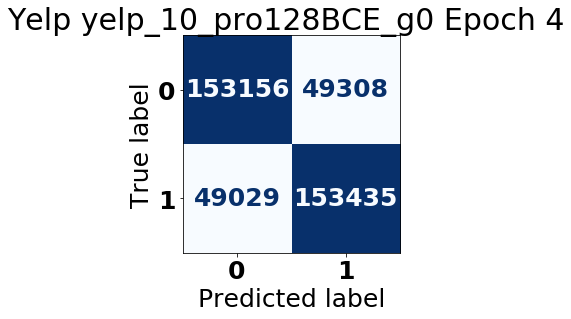

2020-07-13 12:19:12,491 : INFO : wrote 359 events to disk


Time for [evaluate model - 5]: 0:20:20.648355
Train model on group fold (('Restaurants', 'restaurants'), ('Mass Media', 'massmedia'), ('Financial Services', 'financialservices')) #238880...
Start on [prepare training / validation data] ...
Time for [prepare training / validation data]: 0:00:31.495632


  0%|          | 170/238880 [00:00<02:21, 1682.35it/s]

Start on [train model - 5] ...
Start on [setup training] ...


  0%|          | 0/7471 [00:00<?, ?it/s]

Time for [setup training]: 0:02:05.559981
Start on [training] ...
Start on [epoch 0] ...


  0%|          | 1/7471 [00:00<40:23,  3.08it/s]2020-07-13 12:21:51,007 : INFO : successfully opened events file: data/yelp_10_pro128BCE_g1/events.out.tfevents.1594635710.cuda2
2020-07-13 12:21:51,018 : INFO : wrote 1 event to disk
2020-07-13 12:21:51,018 : INFO : wrote 1 event to disk
  7%|▋         | 500/7471 [02:08<30:12,  3.85it/s]

[Epoch 0 Batch 500/7471] loss=0.5120, lr=0.0000050, acc=0.739 - time 0:02:08.362599


 13%|█▎        | 1000/7471 [04:17<27:50,  3.87it/s]

[Epoch 0 Batch 1000/7471] loss=0.4917, lr=0.0000050, acc=0.744 - time 0:02:09.456497


 20%|██        | 1500/7471 [06:27<26:01,  3.82it/s]

[Epoch 0 Batch 1500/7471] loss=0.4753, lr=0.0000050, acc=0.748 - time 0:02:09.680984


 27%|██▋       | 2000/7471 [08:37<23:34,  3.87it/s]

[Epoch 0 Batch 2000/7471] loss=0.4720, lr=0.0000050, acc=0.752 - time 0:02:09.763621


 33%|███▎      | 2500/7471 [10:46<21:42,  3.82it/s]

[Epoch 0 Batch 2500/7471] loss=0.4672, lr=0.0000050, acc=0.754 - time 0:02:09.721231


 40%|████      | 3000/7471 [12:56<19:26,  3.83it/s]

[Epoch 0 Batch 3000/7471] loss=0.4652, lr=0.0000050, acc=0.756 - time 0:02:09.698188


 47%|████▋     | 3500/7471 [15:06<17:14,  3.84it/s]

[Epoch 0 Batch 3500/7471] loss=0.4661, lr=0.0000050, acc=0.758 - time 0:02:09.974249


 54%|█████▎    | 4000/7471 [17:16<14:53,  3.88it/s]

[Epoch 0 Batch 4000/7471] loss=0.4563, lr=0.0000050, acc=0.760 - time 0:02:09.672021


 60%|██████    | 4500/7471 [19:26<12:54,  3.83it/s]

[Epoch 0 Batch 4500/7471] loss=0.4591, lr=0.0000050, acc=0.761 - time 0:02:09.909353


 67%|██████▋   | 5000/7471 [21:36<10:37,  3.88it/s]

[Epoch 0 Batch 5000/7471] loss=0.4479, lr=0.0000050, acc=0.763 - time 0:02:09.767424


 74%|███████▎  | 5500/7471 [23:45<08:35,  3.82it/s]

[Epoch 0 Batch 5500/7471] loss=0.4518, lr=0.0000050, acc=0.764 - time 0:02:09.720855


 80%|████████  | 6000/7471 [25:55<06:24,  3.83it/s]

[Epoch 0 Batch 6000/7471] loss=0.4434, lr=0.0000050, acc=0.765 - time 0:02:09.702296


 87%|████████▋ | 6500/7471 [28:05<04:14,  3.82it/s]

[Epoch 0 Batch 6500/7471] loss=0.4360, lr=0.0000050, acc=0.767 - time 0:02:09.794337


 94%|█████████▎| 7000/7471 [30:14<02:03,  3.82it/s]

[Epoch 0 Batch 7000/7471] loss=0.4378, lr=0.0000050, acc=0.768 - time 0:02:09.716790


100%|██████████| 7471/7471 [32:17<00:00,  3.86it/s]


Time for [epoch 0]: 0:32:17.257499


  0%|          | 0/7471 [00:00<?, ?it/s]

Start on [epoch 1] ...


  7%|▋         | 500/7471 [02:09<29:57,  3.88it/s]

[Epoch 1 Batch 500/7471] loss=0.4066, lr=0.0000050, acc=0.806 - time 0:02:09.589107


 13%|█▎        | 1000/7471 [04:19<27:45,  3.89it/s]

[Epoch 1 Batch 1000/7471] loss=0.4120, lr=0.0000050, acc=0.804 - time 0:02:09.766406


 20%|██        | 1500/7471 [06:29<26:06,  3.81it/s]

[Epoch 1 Batch 1500/7471] loss=0.4135, lr=0.0000050, acc=0.802 - time 0:02:09.819540


 27%|██▋       | 2000/7471 [08:38<23:50,  3.82it/s]

[Epoch 1 Batch 2000/7471] loss=0.4061, lr=0.0000050, acc=0.802 - time 0:02:09.651501


 33%|███▎      | 2500/7471 [10:48<21:41,  3.82it/s]

[Epoch 1 Batch 2500/7471] loss=0.4120, lr=0.0000050, acc=0.802 - time 0:02:09.953737


 40%|████      | 3000/7471 [12:58<19:23,  3.84it/s]

[Epoch 1 Batch 3000/7471] loss=0.4163, lr=0.0000050, acc=0.802 - time 0:02:09.911230


 47%|████▋     | 3500/7471 [15:08<16:54,  3.91it/s]

[Epoch 1 Batch 3500/7471] loss=0.4039, lr=0.0000050, acc=0.803 - time 0:02:09.758865


 54%|█████▎    | 4000/7471 [17:17<15:02,  3.85it/s]

[Epoch 1 Batch 4000/7471] loss=0.4058, lr=0.0000050, acc=0.803 - time 0:02:09.332527


 60%|██████    | 4500/7471 [19:27<12:45,  3.88it/s]

[Epoch 1 Batch 4500/7471] loss=0.4046, lr=0.0000050, acc=0.804 - time 0:02:09.727162


 67%|██████▋   | 5000/7471 [21:36<10:46,  3.82it/s]

[Epoch 1 Batch 5000/7471] loss=0.4023, lr=0.0000050, acc=0.804 - time 0:02:09.336790


 74%|███████▎  | 5500/7471 [23:46<08:28,  3.88it/s]

[Epoch 1 Batch 5500/7471] loss=0.4077, lr=0.0000050, acc=0.804 - time 0:02:10.013693


 80%|████████  | 6000/7471 [25:56<06:17,  3.89it/s]

[Epoch 1 Batch 6000/7471] loss=0.4026, lr=0.0000050, acc=0.805 - time 0:02:09.662988


 87%|████████▋ | 6500/7471 [28:06<04:12,  3.84it/s]

[Epoch 1 Batch 6500/7471] loss=0.4166, lr=0.0000050, acc=0.804 - time 0:02:09.875192


 94%|█████████▎| 7000/7471 [30:16<01:59,  3.93it/s]

[Epoch 1 Batch 7000/7471] loss=0.4128, lr=0.0000050, acc=0.804 - time 0:02:09.881097


100%|██████████| 7471/7471 [32:18<00:00,  3.85it/s]


Time for [epoch 1]: 0:32:18.803562


  0%|          | 0/7471 [00:00<?, ?it/s]

Start on [epoch 2] ...


  7%|▋         | 500/7471 [02:09<30:25,  3.82it/s]

[Epoch 2 Batch 500/7471] loss=0.3718, lr=0.0000050, acc=0.825 - time 0:02:09.765035


 13%|█▎        | 1000/7471 [04:19<27:51,  3.87it/s]

[Epoch 2 Batch 1000/7471] loss=0.3853, lr=0.0000050, acc=0.823 - time 0:02:09.981060


 20%|██        | 1500/7471 [06:29<25:57,  3.83it/s]

[Epoch 2 Batch 1500/7471] loss=0.3670, lr=0.0000050, acc=0.825 - time 0:02:10.010566


 27%|██▋       | 2000/7471 [08:47<23:44,  3.84it/s]  

[Epoch 2 Batch 2000/7471] loss=0.3762, lr=0.0000050, acc=0.825 - time 0:02:17.422859


 33%|███▎      | 2500/7471 [10:57<21:34,  3.84it/s]

[Epoch 2 Batch 2500/7471] loss=0.3726, lr=0.0000050, acc=0.825 - time 0:02:09.857144


 40%|████      | 3000/7471 [13:06<19:08,  3.89it/s]

[Epoch 2 Batch 3000/7471] loss=0.3667, lr=0.0000050, acc=0.825 - time 0:02:09.854442


 47%|████▋     | 3500/7471 [15:16<17:25,  3.80it/s]

[Epoch 2 Batch 3500/7471] loss=0.3650, lr=0.0000050, acc=0.826 - time 0:02:09.766200


 54%|█████▎    | 4000/7471 [17:26<14:59,  3.86it/s]

[Epoch 2 Batch 4000/7471] loss=0.3756, lr=0.0000050, acc=0.826 - time 0:02:09.737278


 60%|██████    | 4500/7471 [19:36<12:57,  3.82it/s]

[Epoch 2 Batch 4500/7471] loss=0.3707, lr=0.0000050, acc=0.826 - time 0:02:09.952749


 67%|██████▋   | 5000/7471 [21:46<10:37,  3.88it/s]

[Epoch 2 Batch 5000/7471] loss=0.3746, lr=0.0000050, acc=0.825 - time 0:02:09.931785


 74%|███████▎  | 5500/7471 [23:56<08:27,  3.88it/s]

[Epoch 2 Batch 5500/7471] loss=0.3690, lr=0.0000050, acc=0.825 - time 0:02:09.984230


 80%|████████  | 6000/7471 [26:06<06:20,  3.87it/s]

[Epoch 2 Batch 6000/7471] loss=0.3711, lr=0.0000050, acc=0.826 - time 0:02:10.039949


 87%|████████▋ | 6500/7471 [28:16<04:11,  3.86it/s]

[Epoch 2 Batch 6500/7471] loss=0.3713, lr=0.0000050, acc=0.826 - time 0:02:09.845341


 94%|█████████▎| 7000/7471 [30:26<02:03,  3.81it/s]

[Epoch 2 Batch 7000/7471] loss=0.3816, lr=0.0000050, acc=0.825 - time 0:02:09.905296


100%|██████████| 7471/7471 [32:28<00:00,  3.83it/s]


Time for [epoch 2]: 0:32:28.276126


  0%|          | 0/7471 [00:00<?, ?it/s]

Start on [epoch 3] ...


  7%|▋         | 500/7471 [02:10<29:43,  3.91it/s]

[Epoch 3 Batch 500/7471] loss=0.3332, lr=0.0000050, acc=0.847 - time 0:02:10.050407


 13%|█▎        | 1000/7471 [04:19<28:00,  3.85it/s]

[Epoch 3 Batch 1000/7471] loss=0.3332, lr=0.0000050, acc=0.848 - time 0:02:09.670554


 20%|██        | 1500/7471 [06:29<26:08,  3.81it/s]

[Epoch 3 Batch 1500/7471] loss=0.3369, lr=0.0000050, acc=0.848 - time 0:02:09.996833


 27%|██▋       | 2000/7471 [08:39<23:15,  3.92it/s]

[Epoch 3 Batch 2000/7471] loss=0.3253, lr=0.0000050, acc=0.849 - time 0:02:09.671725


 33%|███▎      | 2500/7471 [10:49<21:45,  3.81it/s]

[Epoch 3 Batch 2500/7471] loss=0.3365, lr=0.0000050, acc=0.848 - time 0:02:10.077430


 40%|████      | 3000/7471 [12:59<19:28,  3.83it/s]

[Epoch 3 Batch 3000/7471] loss=0.3319, lr=0.0000050, acc=0.848 - time 0:02:10.151968


 47%|████▋     | 3500/7471 [15:09<17:16,  3.83it/s]

[Epoch 3 Batch 3500/7471] loss=0.3310, lr=0.0000050, acc=0.848 - time 0:02:09.924724


 54%|█████▎    | 4000/7471 [17:19<15:10,  3.81it/s]

[Epoch 3 Batch 4000/7471] loss=0.3252, lr=0.0000050, acc=0.848 - time 0:02:09.677320


 60%|██████    | 4500/7471 [19:29<12:45,  3.88it/s]

[Epoch 3 Batch 4500/7471] loss=0.3399, lr=0.0000050, acc=0.848 - time 0:02:09.846347


 67%|██████▋   | 5000/7471 [21:39<10:39,  3.87it/s]

[Epoch 3 Batch 5000/7471] loss=0.3423, lr=0.0000050, acc=0.847 - time 0:02:10.101689


 74%|███████▎  | 5500/7471 [23:48<08:36,  3.82it/s]

[Epoch 3 Batch 5500/7471] loss=0.3308, lr=0.0000050, acc=0.847 - time 0:02:09.717399


 80%|████████  | 6000/7471 [25:58<06:19,  3.87it/s]

[Epoch 3 Batch 6000/7471] loss=0.3462, lr=0.0000050, acc=0.847 - time 0:02:09.829787


 87%|████████▋ | 6500/7471 [28:08<04:13,  3.84it/s]

[Epoch 3 Batch 6500/7471] loss=0.3381, lr=0.0000050, acc=0.847 - time 0:02:09.883598


 94%|█████████▎| 7000/7471 [30:18<01:58,  3.99it/s]

[Epoch 3 Batch 7000/7471] loss=0.3359, lr=0.0000050, acc=0.847 - time 0:02:09.869622


100%|██████████| 7471/7471 [32:20<00:00,  3.85it/s]


Time for [epoch 3]: 0:32:20.821925


  0%|          | 0/7471 [00:00<?, ?it/s]

Start on [epoch 4] ...


  7%|▋         | 500/7471 [02:09<30:22,  3.82it/s]

[Epoch 4 Batch 500/7471] loss=0.2900, lr=0.0000050, acc=0.874 - time 0:02:09.760407


 13%|█▎        | 1000/7471 [04:19<28:08,  3.83it/s]

[Epoch 4 Batch 1000/7471] loss=0.2976, lr=0.0000050, acc=0.870 - time 0:02:09.932398


 20%|██        | 1500/7471 [06:29<25:45,  3.86it/s]

[Epoch 4 Batch 1500/7471] loss=0.2888, lr=0.0000050, acc=0.870 - time 0:02:10.096919


 27%|██▋       | 2000/7471 [08:39<23:25,  3.89it/s]

[Epoch 4 Batch 2000/7471] loss=0.2899, lr=0.0000050, acc=0.871 - time 0:02:09.933394


 33%|███▎      | 2500/7471 [10:49<21:35,  3.84it/s]

[Epoch 4 Batch 2500/7471] loss=0.2992, lr=0.0000050, acc=0.870 - time 0:02:09.924676


 40%|████      | 3000/7471 [12:59<19:30,  3.82it/s]

[Epoch 4 Batch 3000/7471] loss=0.2915, lr=0.0000050, acc=0.870 - time 0:02:09.919902


 47%|████▋     | 3500/7471 [15:09<17:15,  3.83it/s]

[Epoch 4 Batch 3500/7471] loss=0.3015, lr=0.0000050, acc=0.869 - time 0:02:09.720677


 54%|█████▎    | 4000/7471 [17:19<15:07,  3.82it/s]

[Epoch 4 Batch 4000/7471] loss=0.3040, lr=0.0000050, acc=0.869 - time 0:02:09.921461


 60%|██████    | 4500/7471 [19:29<12:45,  3.88it/s]

[Epoch 4 Batch 4500/7471] loss=0.2967, lr=0.0000050, acc=0.869 - time 0:02:09.863621


 67%|██████▋   | 5000/7471 [21:38<10:42,  3.84it/s]

[Epoch 4 Batch 5000/7471] loss=0.3010, lr=0.0000050, acc=0.869 - time 0:02:09.617503


 74%|███████▎  | 5500/7471 [23:48<08:38,  3.80it/s]

[Epoch 4 Batch 5500/7471] loss=0.3103, lr=0.0000050, acc=0.868 - time 0:02:09.846283


 80%|████████  | 6000/7471 [25:58<06:25,  3.82it/s]

[Epoch 4 Batch 6000/7471] loss=0.3053, lr=0.0000050, acc=0.868 - time 0:02:09.922786


 87%|████████▋ | 6500/7471 [28:08<04:13,  3.84it/s]

[Epoch 4 Batch 6500/7471] loss=0.3043, lr=0.0000050, acc=0.868 - time 0:02:09.741960


 94%|█████████▎| 7000/7471 [30:18<01:59,  3.93it/s]

[Epoch 4 Batch 7000/7471] loss=0.3014, lr=0.0000050, acc=0.868 - time 0:02:09.874059


100%|██████████| 7471/7471 [32:20<00:00,  3.85it/s]


Time for [epoch 4]: 0:32:20.121168
Time for [training]: 2:41:47.013108


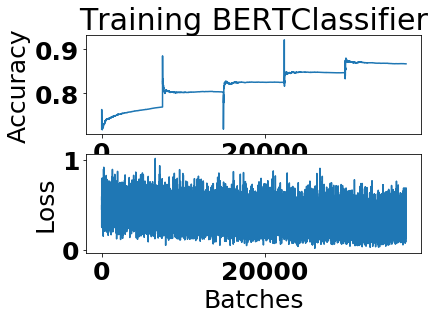

2020-07-13 15:03:37,865 : INFO : wrote 809 events to disk
  0%|          | 0/5897 [00:00<?, ?it/s]

Time for [train model - 5]: 2:43:52.758518
Start on [evaluate model - 5] ...
Start on [prediction] ...


2020-07-13 15:03:37,984 : INFO : successfully opened events file: data/yelp_10_pro128BCE_g1/events.out.tfevents.1594645417.cuda2
2020-07-13 15:03:37,988 : INFO : wrote 1 event to disk
2020-07-13 15:03:37,989 : INFO : wrote 1 event to disk
100%|██████████| 5897/5897 [09:33<00:00, 10.28it/s]


Time for [prediction]: 0:09:33.757098
Accuracy in epoch 4: 0.8127967610649482
Confusion Matrix:
[[73680 20672]
 [14654 79698]]

CM: [73680 20672 14654 79698] 
[tn, fp, fn, tp]
  accuracy: 0.813
 precision: 0.814
    recall: 0.813
  f1-score: 0.813

Accuracy:  0.813 

Report for [BERTClassifier - yelp_10_pro128BCE_g1]:
              precision    recall  f1-score   support

           0       0.83      0.78      0.81     94352
           1       0.79      0.84      0.82     94352

    accuracy                           0.81    188704
   macro avg       0.81      0.81      0.81    188704
weighted avg       0.81      0.81      0.81    188704



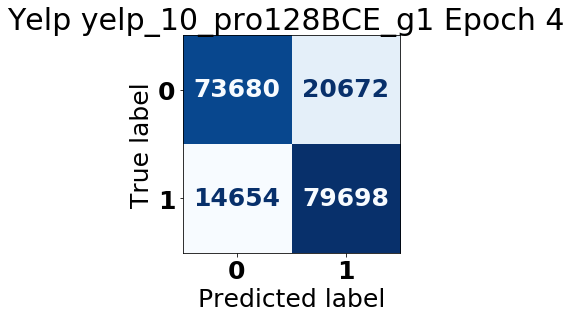

2020-07-13 15:13:13,227 : INFO : wrote 11793 events to disk


Time for [evaluate model - 5]: 0:09:35.362222
Train model on group fold (('Active Life', 'active'), ('Arts & Entertainment', 'arts'), ('Home Services', 'homeservices')) #26384...
Start on [prepare training / validation data] ...
Time for [prepare training / validation data]: 0:00:32.523402


  1%|          | 147/26384 [00:00<00:17, 1459.11it/s]

Start on [train model - 5] ...
Start on [setup training] ...


  0%|          | 0/829 [00:00<?, ?it/s]

Time for [setup training]: 0:00:17.914699
Start on [training] ...
Start on [epoch 0] ...


  0%|          | 1/829 [00:00<04:15,  3.24it/s]2020-07-13 15:14:05,556 : INFO : successfully opened events file: data/yelp_10_pro128BCE_g2/events.out.tfevents.1594646045.cuda2
2020-07-13 15:14:05,579 : INFO : wrote 1 event to disk
2020-07-13 15:14:05,580 : INFO : wrote 1 event to disk
 60%|██████    | 500/829 [02:10<01:27,  3.78it/s]

[Epoch 0 Batch 500/829] loss=0.4079, lr=0.0000050, acc=0.808 - time 0:02:10.632312


100%|██████████| 829/829 [03:37<00:00,  3.81it/s]


Time for [epoch 0]: 0:03:37.616406


  0%|          | 0/829 [00:00<?, ?it/s]

Start on [epoch 1] ...


 60%|██████    | 500/829 [02:11<01:26,  3.79it/s]

[Epoch 1 Batch 500/829] loss=0.3383, lr=0.0000050, acc=0.843 - time 0:02:11.492323


100%|██████████| 829/829 [03:38<00:00,  3.80it/s]


Time for [epoch 1]: 0:03:38.184577


  0%|          | 0/829 [00:00<?, ?it/s]

Start on [epoch 2] ...


 60%|██████    | 500/829 [02:11<01:26,  3.81it/s]

[Epoch 2 Batch 500/829] loss=0.2667, lr=0.0000050, acc=0.883 - time 0:02:11.455590


100%|██████████| 829/829 [03:38<00:00,  3.80it/s]


Time for [epoch 2]: 0:03:38.102072


  0%|          | 0/829 [00:00<?, ?it/s]

Start on [epoch 3] ...


 60%|██████    | 500/829 [02:11<01:26,  3.80it/s]

[Epoch 3 Batch 500/829] loss=0.2146, lr=0.0000050, acc=0.911 - time 0:02:11.658191


100%|██████████| 829/829 [03:38<00:00,  3.80it/s]


Time for [epoch 3]: 0:03:38.029740


  0%|          | 0/829 [00:00<?, ?it/s]

Start on [epoch 4] ...


 60%|██████    | 500/829 [02:11<01:26,  3.79it/s]

[Epoch 4 Batch 500/829] loss=0.1708, lr=0.0000050, acc=0.934 - time 0:02:11.234726


100%|██████████| 829/829 [03:45<00:00,  3.68it/s]


Time for [epoch 4]: 0:03:45.466586
Time for [training]: 0:18:19.122284


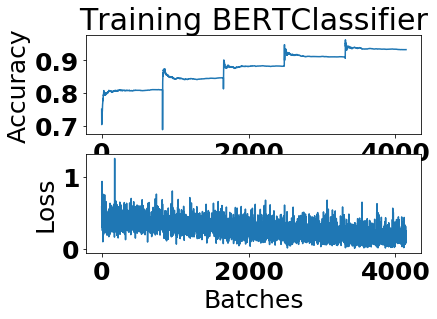

2020-07-13 15:32:24,505 : INFO : wrote 3729 events to disk
  0%|          | 0/12538 [00:00<?, ?it/s]

Time for [train model - 5]: 0:18:37.176113
Start on [evaluate model - 5] ...
Start on [prediction] ...


2020-07-13 15:32:24,611 : INFO : successfully opened events file: data/yelp_10_pro128BCE_g2/events.out.tfevents.1594647144.cuda2
2020-07-13 15:32:24,620 : INFO : wrote 1 event to disk
2020-07-13 15:32:24,621 : INFO : wrote 1 event to disk
100%|██████████| 12538/12538 [20:02<00:00, 10.43it/s]


Time for [prediction]: 0:20:02.101851
Accuracy in epoch 4: 0.8575648055832502
Confusion Matrix:
[[173496  27104]
 [ 30041 170559]]

CM: [173496  27104  30041 170559] 
[tn, fp, fn, tp]
  accuracy: 0.858
 precision: 0.858
    recall: 0.858
  f1-score: 0.858

Accuracy:  0.858 

Report for [BERTClassifier - yelp_10_pro128BCE_g2]:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86    200600
           1       0.86      0.85      0.86    200600

    accuracy                           0.86    401200
   macro avg       0.86      0.86      0.86    401200
weighted avg       0.86      0.86      0.86    401200



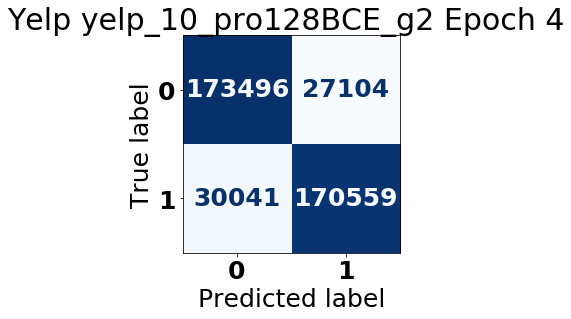

2020-07-13 15:52:29,757 : INFO : wrote 43 events to disk


Time for [evaluate model - 5]: 0:20:05.251926
Train model on group fold (('Public Services & Government', 'publicservicesgovt'), ('Local Services', 'localservices'), ('Event Planning & Services', 'eventservices')) #6224...
Start on [prepare training / validation data] ...
Time for [prepare training / validation data]: 0:00:31.604840


  3%|▎         | 170/6224 [00:00<00:03, 1692.34it/s]

Start on [train model - 5] ...
Start on [setup training] ...


  0%|          | 0/200 [00:00<?, ?it/s]

Time for [setup training]: 0:00:03.527087
Start on [training] ...
Start on [epoch 0] ...


  0%|          | 1/200 [00:00<01:03,  3.14it/s]2020-07-13 15:53:06,837 : INFO : successfully opened events file: data/yelp_10_pro128BCE_g3/events.out.tfevents.1594648386.cuda2
2020-07-13 15:53:06,838 : INFO : wrote 1 event to disk
2020-07-13 15:53:06,838 : INFO : wrote 1 event to disk
100%|██████████| 200/200 [00:50<00:00,  3.96it/s]


Time for [epoch 0]: 0:00:50.551849


  0%|          | 0/200 [00:00<?, ?it/s]

Start on [epoch 1] ...


100%|██████████| 200/200 [00:50<00:00,  3.93it/s]


Time for [epoch 1]: 0:00:50.858519


  0%|          | 0/200 [00:00<?, ?it/s]

Start on [epoch 2] ...


100%|██████████| 200/200 [00:50<00:00,  3.93it/s]


Time for [epoch 2]: 0:00:50.874795


  0%|          | 0/200 [00:00<?, ?it/s]

Start on [epoch 3] ...


100%|██████████| 200/200 [00:50<00:00,  3.93it/s]


Time for [epoch 3]: 0:00:50.879905


  0%|          | 0/200 [00:00<?, ?it/s]

Start on [epoch 4] ...


100%|██████████| 200/200 [00:50<00:00,  3.93it/s]


Time for [epoch 4]: 0:00:50.872289
Time for [training]: 0:04:15.757308


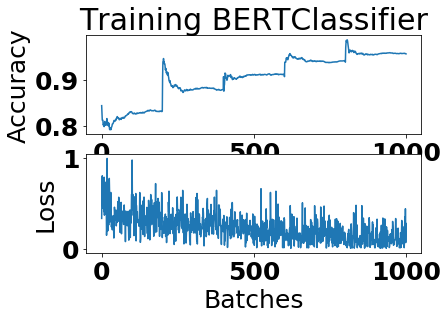

2020-07-13 15:57:22,378 : INFO : wrote 1999 events to disk
  0%|          | 0/13168 [00:00<?, ?it/s]

Time for [train model - 5]: 0:04:19.411256
Start on [evaluate model - 5] ...
Start on [prediction] ...


2020-07-13 15:57:22,484 : INFO : successfully opened events file: data/yelp_10_pro128BCE_g3/events.out.tfevents.1594648642.cuda2
2020-07-13 15:57:22,493 : INFO : wrote 1 event to disk
2020-07-13 15:57:22,494 : INFO : wrote 1 event to disk
100%|██████████| 13168/13168 [21:06<00:00, 10.40it/s]


Time for [prediction]: 0:21:06.569099
Accuracy in epoch 4: 0.8616076514144675
Confusion Matrix:
[[184019  26661]
 [ 31652 179028]]

CM: [184019  26661  31652 179028] 
[tn, fp, fn, tp]
  accuracy: 0.862
 precision: 0.862
    recall: 0.862
  f1-score: 0.862

Accuracy:  0.862 

Report for [BERTClassifier - yelp_10_pro128BCE_g3]:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86    210680
           1       0.87      0.85      0.86    210680

    accuracy                           0.86    421360
   macro avg       0.86      0.86      0.86    421360
weighted avg       0.86      0.86      0.86    421360



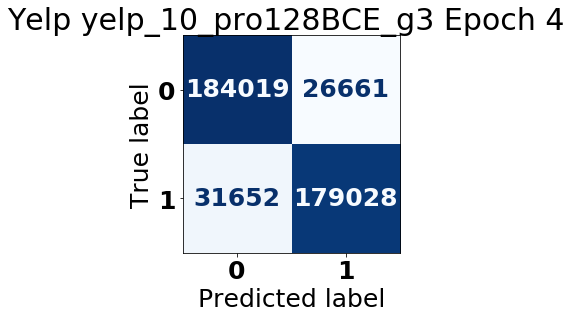

2020-07-13 16:18:32,403 : INFO : wrote 1383 events to disk


Time for [evaluate model - 5]: 0:21:10.025442
Train model on group fold (('Automotive', 'auto'), ('Education', 'education'), ('Nightlife', 'nightlife')) #33328...
Start on [prepare training / validation data] ...
Time for [prepare training / validation data]: 0:00:32.272577


  0%|          | 153/33328 [00:00<00:21, 1526.28it/s]

Start on [train model - 5] ...
Start on [setup training] ...


  0%|          | 0/1045 [00:00<?, ?it/s]

Time for [setup training]: 0:00:19.834401
Start on [training] ...
Start on [epoch 0] ...


  0%|          | 1/1045 [00:00<05:32,  3.14it/s]2020-07-13 16:19:26,636 : INFO : successfully opened events file: data/yelp_10_pro128BCE_g4/events.out.tfevents.1594649966.cuda2
2020-07-13 16:19:26,636 : INFO : wrote 1 event to disk
2020-07-13 16:19:26,637 : INFO : wrote 1 event to disk
 48%|████▊     | 500/1045 [02:10<02:23,  3.81it/s]

[Epoch 0 Batch 500/1045] loss=0.4098, lr=0.0000050, acc=0.808 - time 0:02:10.027778


 96%|█████████▌| 1000/1045 [04:20<00:11,  3.80it/s]

[Epoch 0 Batch 1000/1045] loss=0.3755, lr=0.0000050, acc=0.814 - time 0:02:10.240895


100%|██████████| 1045/1045 [04:32<00:00,  3.84it/s]


Time for [epoch 0]: 0:04:32.037118


  0%|          | 0/1045 [00:00<?, ?it/s]

Start on [epoch 1] ...


 48%|████▊     | 500/1045 [02:10<02:21,  3.84it/s]

[Epoch 1 Batch 500/1045] loss=0.3236, lr=0.0000050, acc=0.852 - time 0:02:10.228417


 96%|█████████▌| 1000/1045 [04:20<00:10,  4.35it/s]

[Epoch 1 Batch 1000/1045] loss=0.3165, lr=0.0000050, acc=0.853 - time 0:02:10.448397


100%|██████████| 1045/1045 [04:32<00:00,  3.84it/s]


Time for [epoch 1]: 0:04:32.398813


  0%|          | 0/1045 [00:00<?, ?it/s]

Start on [epoch 2] ...


 48%|████▊     | 500/1045 [02:10<02:22,  3.81it/s]

[Epoch 2 Batch 500/1045] loss=0.2660, lr=0.0000050, acc=0.883 - time 0:02:10.404618


 96%|█████████▌| 999/1045 [04:20<00:12,  3.81it/s]

[Epoch 2 Batch 1000/1045] loss=0.2685, lr=0.0000050, acc=0.883 - time 0:02:10.203960


100%|██████████| 1045/1045 [04:32<00:00,  3.84it/s]


Time for [epoch 2]: 0:04:32.445702


  0%|          | 0/1045 [00:00<?, ?it/s]

Start on [epoch 3] ...


 48%|████▊     | 500/1045 [02:10<02:23,  3.79it/s]

[Epoch 3 Batch 500/1045] loss=0.2160, lr=0.0000050, acc=0.908 - time 0:02:10.130870


 96%|█████████▌| 1000/1045 [04:20<00:11,  3.83it/s]

[Epoch 3 Batch 1000/1045] loss=0.2220, lr=0.0000050, acc=0.908 - time 0:02:10.417269


100%|██████████| 1045/1045 [04:32<00:00,  3.84it/s]


Time for [epoch 3]: 0:04:32.341463


  0%|          | 0/1045 [00:00<?, ?it/s]

Start on [epoch 4] ...


 48%|████▊     | 500/1045 [02:10<02:23,  3.79it/s]

[Epoch 4 Batch 500/1045] loss=0.1681, lr=0.0000050, acc=0.934 - time 0:02:10.497089


 96%|█████████▌| 1000/1045 [04:20<00:11,  3.79it/s]

[Epoch 4 Batch 1000/1045] loss=0.1773, lr=0.0000050, acc=0.931 - time 0:02:09.973393


100%|██████████| 1045/1045 [04:32<00:00,  3.84it/s]


Time for [epoch 4]: 0:04:32.223118
Time for [training]: 0:22:43.172700


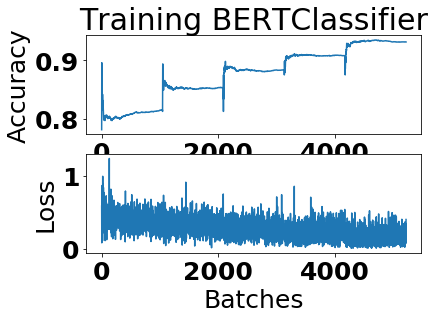

2020-07-13 16:42:09,614 : INFO : wrote 1247 events to disk
  0%|          | 0/12321 [00:00<?, ?it/s]

Time for [train model - 5]: 0:23:03.144770
Start on [evaluate model - 5] ...
Start on [prediction] ...


2020-07-13 16:42:09,717 : INFO : successfully opened events file: data/yelp_10_pro128BCE_g4/events.out.tfevents.1594651329.cuda2
2020-07-13 16:42:09,727 : INFO : wrote 1 event to disk
2020-07-13 16:42:09,727 : INFO : wrote 1 event to disk
100%|██████████| 12321/12321 [19:40<00:00, 10.44it/s]


Time for [prediction]: 0:19:40.512943
Accuracy in epoch 4: 0.861660951260095
Confusion Matrix:
[[169574  27554]
 [ 26987 170141]]

CM: [169574  27554  26987 170141] 
[tn, fp, fn, tp]
  accuracy: 0.862
 precision: 0.862
    recall: 0.862
  f1-score: 0.862

Accuracy:  0.862 

Report for [BERTClassifier - yelp_10_pro128BCE_g4]:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86    197128
           1       0.86      0.86      0.86    197128

    accuracy                           0.86    394256
   macro avg       0.86      0.86      0.86    394256
weighted avg       0.86      0.86      0.86    394256



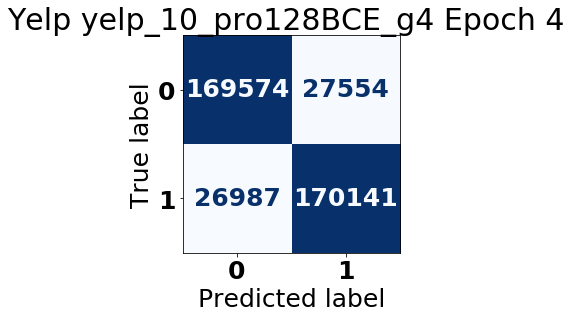

2020-07-13 17:01:53,278 : INFO : wrote 12041 events to disk


Time for [evaluate model - 5]: 0:19:43.664819
Train model on group fold (('Hotels & Travel', 'hotelstravel'), ('Professional Services', 'professional'), ('Pets', 'pets')) #13008...
Start on [prepare training / validation data] ...
Time for [prepare training / validation data]: 0:00:39.852894


  1%|          | 161/13008 [00:00<00:07, 1608.96it/s]

Start on [train model - 5] ...
Start on [setup training] ...


  0%|          | 0/413 [00:00<?, ?it/s]

Time for [setup training]: 0:00:08.741012
Start on [training] ...
Start on [epoch 0] ...


  0%|          | 1/413 [00:00<02:07,  3.22it/s]2020-07-13 17:02:43,793 : INFO : successfully opened events file: data/yelp_10_pro128BCE_g5/events.out.tfevents.1594652563.cuda2
2020-07-13 17:02:43,810 : INFO : wrote 1 event to disk
2020-07-13 17:02:43,815 : INFO : wrote 1 event to disk
100%|██████████| 413/413 [01:47<00:00,  3.86it/s]


Time for [epoch 0]: 0:01:47.097724


  0%|          | 0/413 [00:00<?, ?it/s]

Start on [epoch 1] ...


100%|██████████| 413/413 [01:47<00:00,  3.84it/s]


Time for [epoch 1]: 0:01:47.553868


  0%|          | 0/413 [00:00<?, ?it/s]

Start on [epoch 2] ...


100%|██████████| 413/413 [01:47<00:00,  3.84it/s]


Time for [epoch 2]: 0:01:47.560860


  0%|          | 0/413 [00:00<?, ?it/s]

Start on [epoch 3] ...


100%|██████████| 413/413 [01:47<00:00,  3.84it/s]


Time for [epoch 3]: 0:01:47.473487


  0%|          | 0/413 [00:00<?, ?it/s]

Start on [epoch 4] ...


100%|██████████| 413/413 [01:47<00:00,  3.85it/s]


Time for [epoch 4]: 0:01:47.398614
Time for [training]: 0:08:58.816051


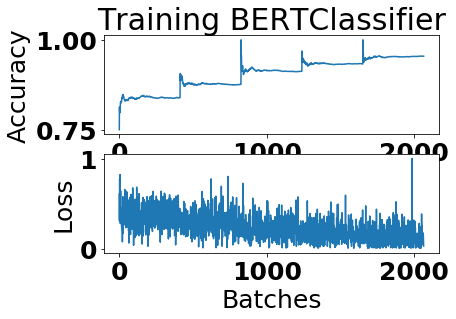

2020-07-13 17:11:42,418 : INFO : wrote 4129 events to disk
  0%|          | 0/12956 [00:00<?, ?it/s]

Time for [train model - 5]: 0:09:07.686425
Start on [evaluate model - 5] ...
Start on [prediction] ...


2020-07-13 17:11:42,523 : INFO : successfully opened events file: data/yelp_10_pro128BCE_g5/events.out.tfevents.1594653102.cuda2
2020-07-13 17:11:42,533 : INFO : wrote 1 event to disk
2020-07-13 17:11:42,533 : INFO : wrote 1 event to disk
100%|██████████| 12956/12956 [20:44<00:00, 10.41it/s]


Time for [prediction]: 0:20:44.585230
Accuracy in epoch 4: 0.8618733356489522
Confusion Matrix:
[[181005  26283]
 [ 30981 176307]]

CM: [181005  26283  30981 176307] 
[tn, fp, fn, tp]
  accuracy: 0.862
 precision: 0.862
    recall: 0.862
  f1-score: 0.862

Accuracy:  0.862 

Report for [BERTClassifier - yelp_10_pro128BCE_g5]:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86    207288
           1       0.87      0.85      0.86    207288

    accuracy                           0.86    414576
   macro avg       0.86      0.86      0.86    414576
weighted avg       0.86      0.86      0.86    414576



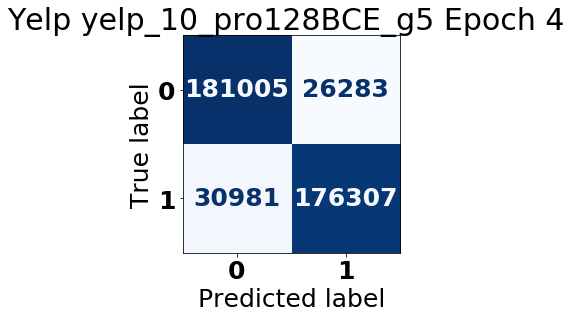

2020-07-13 17:32:30,252 : INFO : wrote 935 events to disk


Time for [evaluate model - 5]: 0:20:47.833728
Train model on group fold (('Food', 'food'), ('Beauty & Spas', 'beautysvc'), ('Health & Medical', 'health')) #87104...
Start on [prepare training / validation data] ...
Time for [prepare training / validation data]: 0:00:31.216715


  0%|          | 167/87104 [00:00<00:52, 1667.61it/s]

Start on [train model - 5] ...
Start on [setup training] ...


  0%|          | 0/2727 [00:00<?, ?it/s]

Time for [setup training]: 0:00:48.097386
Start on [training] ...
Start on [epoch 0] ...


  0%|          | 1/2727 [00:00<14:15,  3.19it/s]2020-07-13 17:33:51,648 : INFO : successfully opened events file: data/yelp_10_pro128BCE_g6/events.out.tfevents.1594654431.cuda2
2020-07-13 17:33:51,649 : INFO : wrote 1 event to disk
2020-07-13 17:33:51,671 : INFO : wrote 1 event to disk
 18%|█▊        | 500/2727 [02:08<09:43,  3.82it/s]

[Epoch 0 Batch 500/2727] loss=0.3855, lr=0.0000050, acc=0.825 - time 0:02:08.809176


 37%|███▋      | 1000/2727 [04:18<07:29,  3.84it/s]

[Epoch 0 Batch 1000/2727] loss=0.3584, lr=0.0000050, acc=0.829 - time 0:02:09.746011


 55%|█████▌    | 1500/2727 [06:28<05:23,  3.80it/s]

[Epoch 0 Batch 1500/2727] loss=0.3494, lr=0.0000050, acc=0.832 - time 0:02:10.167788


 72%|███████▏  | 1960/2727 [08:28<03:19,  3.85it/s]

In [ ]:
for i, (cg_ids, (train_df, dev_df, dev_dfs)) in enumerate(map_cg_train_dev_groups.items()):
    print(f"Train model on group fold {cg_ids} #{len(train_df)}...")
    
    with Timer("prepare training / validation data"):
        X_train, y_train = train_df[names_columns_X], train_df[names_columns_y]
        X_dev, y_dev = dev_df[names_columns_X], dev_df[names_columns_y]

        _, data_train = transform_dataset(X_train, y_train, transform)
        _, data_dev = transform_dataset(X_dev, y_dev, transform)

    run_name = f"{run_name_base}_g{i}"
    fn_run_path = Path(f"data/{run_name}")
    if not fn_run_path.exists():
        fn_run_path.mkdir()

    fn_group = fn_run_path / "group_data.p"
    with open(fn_group, "wb") as fp:
        pickle.dump(cg_ids, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(train_df, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(dev_df, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(dev_dfs, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(groups, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
    with Timer(f"train model - {num_epochs}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=batch_size, lr=5e-6, num_epochs=num_epochs, sw=sw, checkpoint_dir=str(fn_run_path))
        plot_train_stats(stats)
        
    with Timer(f"evaluate model - {num_epochs}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size, sw=sw)
        print(f"Accuracy in epoch {epoch_id}:", metric.get()[1])

        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        with open(fn_run_path / f"{run_name}_g{i}_preds.p", "wb") as fp:
            pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
        report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
        plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp {run_name} Epoch {epoch_id}", values_format="d", cmap="Blues", include_colorbar=False)
        plt.show()

### Evaluate again

In [ ]:
cg_results = dict()

for i, (cg_ids, (train_df, dev_df, dev_dfs)) in enumerate(map_cg_train_dev_groups.items()):
    print(f"Eval model on group fold {cg_ids} #{len(train_df)}...")
    
    with Timer("prepare validation data"):
        X_dev, y_dev = dev_df[names_columns_X], dev_df[names_columns_y]
        _, data_dev = transform_dataset(X_dev, y_dev, transform)

    run_name = f"{run_name_base}_g{i}"
    fn_run_path = Path(f"data/{run_name}")

    fn_group = fn_run_path / "group_data.p"
    #with open(fn_group, "rb") as fp:
    #    pickle.dump(cg_ids, fp, protocol=pickle.HIGHEST_PROTOCOL)
    #    pickle.dump(train_df, fp, protocol=pickle.HIGHEST_PROTOCOL)
    #    pickle.dump(dev_df, fp, protocol=pickle.HIGHEST_PROTOCOL)
    #    pickle.dump(dev_dfs, fp, protocol=pickle.HIGHEST_PROTOCOL)
    #    pickle.dump(groups, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
    fn_model_state = fn_run_path / f"bert.model.checkpoint{epoch_id}.params"
    print(f"Load {fn_model_state} ...")
    model.load_parameters(str(fn_model_state), ctx=ctx)

    with Timer(f"evaluate model - {num_epochs}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size, sw=sw)
        print(f"Accuracy in epoch {epoch_id}:", metric.get()[1])

        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        with open(fn_run_path / f"{run_name}_g{i}_preds.p", "wb") as fp:
            pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
        report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
        plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp {run_name} Epoch {epoch_id}", values_format="d", cmap="Blues", include_colorbar=False)
        plt.show()
        
        cg_results[cg_ids] = compute_metrics(y_true, y_pred, precision=8, averaging="macro", dump=False)

In [ ]:
fn_run_path = Path(f"data/{run_name_base}")
fn_cg_results = fn_run_path / "cg_results.p"
with open(fn_cg_results, "wb") as fp:
    pickle.dump(cg_results, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
fn_run_path = Path(f"data/{run_name_base}")
fn_cg_results = fn_run_path / "cg_results.p"
with open(fn_cg_results, "rb") as fp:
    cg_results = pickle.load(fp)

In [ ]:
fn_run_path = Path(f"data/{run_name_base}")
fn_cg_results = fn_run_path / "cg_results.txt"
with open(fn_cg_results, "w") as fp:
    for cg_ids, (prec, rec, f1, acc, cm) in cg_results.items():
        fp.write(f"{str(cg_ids):<30}: P:{prec * 100:5.2f}%  R:{rec * 100:5.2f}%  F:{f1 * 100:5.2f}%  A:{acc * 100:5.2f}%  -- CM:{cm.flatten().tolist()}\n\n")

In [72]:
cur_cat = None
for cg_ids, (prec, rec, f1, acc, cm) in cg_results.items():
    if cur_cat is None or cur_cat != cg_ids:
        cur_cat = cg_ids
        print(f"\n\n{cg_ids}\n")
    print(f"P:{prec * 100:5.2f}%  R:{rec * 100:5.2f}%  F:{f1 * 100:5.2f}%  A:{acc * 100:5.2f}%")



(('Religious Organizations', 'religiousorgs'), ('Shopping', 'shopping'), ('Local Flavor', 'localflavor'))

P:75.71%  R:75.71%  F:75.71%  A:75.71%


(('Restaurants', 'restaurants'), ('Mass Media', 'massmedia'), ('Financial Services', 'financialservices'))

P:81.41%  R:81.28%  F:81.26%  A:81.28%


(('Active Life', 'active'), ('Arts & Entertainment', 'arts'), ('Home Services', 'homeservices'))

P:85.76%  R:85.76%  F:85.76%  A:85.76%


(('Public Services & Government', 'publicservicesgovt'), ('Local Services', 'localservices'), ('Event Planning & Services', 'eventservices'))

P:86.18%  R:86.16%  F:86.16%  A:86.16%


(('Automotive', 'auto'), ('Education', 'education'), ('Nightlife', 'nightlife'))

P:86.17%  R:86.17%  F:86.17%  A:86.17%


(('Hotels & Travel', 'hotelstravel'), ('Professional Services', 'professional'), ('Pets', 'pets'))

P:86.21%  R:86.19%  F:86.19%  A:86.19%


(('Food', 'food'), ('Beauty & Spas', 'beautysvc'), ('Health & Medical', 'health'))

P:87.21%  R:87.21%  F:87.21%  

In [ ]:
cg_results_single_group = dict()

for i, (cg_ids, (train_df, dev_df, dev_dfs)) in enumerate(map_cg_train_dev_groups.items()):
    print(f"Eval model {cg_ids} #{len(train_df)}...")
    
    cg_groups = [cg_ids_o for cg_ids_o in groups if cg_ids_o != cg_ids]
    
    run_name = f"{run_name_base}_g{i}"
    fn_run_path = Path(f"data/{run_name}")
    
    fn_model_state = fn_run_path / f"bert.model.checkpoint{epoch_id}.params"
    print(f"Load {fn_model_state} ...")
    model.load_parameters(str(fn_model_state), ctx=ctx)

    for cgi, (cg_ids_o, dev_df) in enumerate(zip(cg_groups, dev_dfs)):
        with Timer("prepare validation data"):
            X_dev, y_dev = dev_df[names_columns_X], dev_df[names_columns_y]
            _, data_dev = transform_dataset(X_dev, y_dev, transform)

        with Timer(f"evaluate model - {num_epochs}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
            all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size, sw=sw)
            print(f"Accuracy in epoch {epoch_id}:", metric.get()[1])

            y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
            with open(fn_run_path / f"{run_name}_g{i}sg{cgi}_preds.p", "wb") as fp:
                pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
                pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
            report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name} - {cg_ids_o}", heatmap=False)
            plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp {run_name} Epoch {epoch_id} on group {cg_ids_o}", values_format="d", cmap="Blues", include_colorbar=False)
            plt.show()
            
            # do we have the 
            cg_results_single_group[(cg_ids, cg_ids_o, i, cgi)] = compute_metrics(y_true, y_pred, precision=8, averaging="macro", dump=False)

In [ ]:
fn_run_path = Path(f"data/{run_name_base}")
fn_cg_results_single_group = fn_run_path / "cg_results_single_group.p"
with open(fn_cg_results_single_group, "wb") as fp:
    pickle.dump(cg_results_single_group, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
fn_run_path = Path(f"data/{run_name_base}")
fn_cg_results_single_group = fn_run_path / "cg_results_single_group.p"
with open(fn_cg_results_single_group, "rb") as fp:
    cg_results_single_group = pickle.load(fp)

In [ ]:
fn_run_path = Path(f"data/{run_name_base}")
fn_cg_results_single_group = fn_run_path / "cg_results_single_group.txt"
with open(fn_cg_results_single_group, "w") as fp:
    for (cg_ids, cg_ids_o, i, cgi), (prec, rec, f1, acc, cm) in cg_results_single_group.items():
        fp.write(f"{cg_ids}-{cg_ids_o}-{i}-{cgi}: P:{prec * 100:5.2f}%  R:{rec * 100:5.2f}%  F:{f1 * 100:5.2f}%  A:{acc * 100:5.2f}%  -- CM:{cm.flatten().tolist()}\n\n")

In [73]:
cur_cat = None
for (cg_ids, cg_ids_o, i, cgi), (prec, rec, f1, acc, cm) in cg_results_single_group.items():
    if cur_cat is None or cur_cat != cg_ids:
        cur_cat = cg_ids
        print(f"\n\n{cg_ids}\n")
    print(f"P:{prec * 100:5.2f}%  R:{rec * 100:5.2f}%  F:{f1 * 100:5.2f}%  A:{acc * 100:5.2f}% -- {cg_ids_o}")



(('Religious Organizations', 'religiousorgs'), ('Shopping', 'shopping'), ('Local Flavor', 'localflavor'))

P:73.66%  R:73.66%  F:73.66%  A:73.66% -- (('Restaurants', 'restaurants'), ('Mass Media', 'massmedia'), ('Financial Services', 'financialservices'))
P:77.87%  R:77.86%  F:77.86%  A:77.86% -- (('Active Life', 'active'), ('Arts & Entertainment', 'arts'), ('Home Services', 'homeservices'))
P:80.53%  R:80.49%  F:80.49%  A:80.49% -- (('Public Services & Government', 'publicservicesgovt'), ('Local Services', 'localservices'), ('Event Planning & Services', 'eventservices'))
P:78.09%  R:78.08%  F:78.08%  A:78.08% -- (('Automotive', 'auto'), ('Education', 'education'), ('Nightlife', 'nightlife'))
P:79.10%  R:79.09%  F:79.09%  A:79.09% -- (('Hotels & Travel', 'hotelstravel'), ('Professional Services', 'professional'), ('Pets', 'pets'))
P:78.94%  R:78.94%  F:78.94%  A:78.94% -- (('Food', 'food'), ('Beauty & Spas', 'beautysvc'), ('Health & Medical', 'health'))


(('Restaurants', 'restaurant

In [ ]:
cg_results_single_cat = dict()

for i, (cg_ids, (train_df, dev_df, dev_dfs)) in enumerate(map_cg_train_dev_groups.items()):
    print(f"Eval model {cg_ids} #{len(train_df)}...")
    
    cg_groups = [cg_ids_o for cg_ids_o in groups if cg_ids_o != cg_ids]
    
    run_name = f"{run_name_base}_g{i}"
    fn_run_path = Path(f"data/{run_name}")
    
    fn_model_state = fn_run_path / f"bert.model.checkpoint{num_epochs - 1}.params"
    print(f"Load {fn_model_state} ...")
    model.load_parameters(str(fn_model_state), ctx=ctx)
    
    for cgi, (cg_id, businesses) in enumerate(lookup_rootcat_bid_no_overlap.items()):
        # check if train data, skip since we did not split into eval
        if cg_id in cg_ids:
            continue
        if not businesses:
            print(f"Skip empty df: {cg_id}")
            continue
            
        dev_df = traindev_df[traindev_df.business_id.isin(businesses)]

        with Timer("prepare validation data"):
            X_dev, y_dev = dev_df[names_columns_X], dev_df[names_columns_y]
            _, data_dev = transform_dataset(X_dev, y_dev, transform)

        with Timer(f"evaluate model - {num_epochs}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
            all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size, sw=sw)
            print(f"Accuracy in epoch {epoch_id}:", metric.get()[1])

            y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
            with open(fn_run_path / f"{run_name}_g{i}sc{cgi}_preds.p", "wb") as fp:
                pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
                pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
            report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name} - {cg_id}", heatmap=False)
            plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp {run_name} Epoch {epoch_id} on category {cg_id}", values_format="d", cmap="Blues", include_colorbar=False)
            plt.show()
            
            # do we have the 
            cg_results_single_cat[(cg_ids, cg_id, i, cgi)] = compute_metrics(y_true, y_pred, precision=8, averaging="macro", dump=False)

In [ ]:
fn_run_path = Path(f"data/{run_name_base}")
fn_cg_results_single_cat = fn_run_path / "cg_results_single_cat.p"
with open(fn_cg_results_single_cat, "wb") as fp:
    pickle.dump(cg_results_single_cat, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
fn_run_path = Path(f"data/{run_name_base}")
fn_cg_results_single_cat = fn_run_path / "cg_results_single_cat.p"
with open(fn_cg_results_single_cat, "rb") as fp:
    cg_results_single_cat = pickle.load(fp)

In [ ]:
fn_run_path = Path(f"data/{run_name_base}")
fn_cg_results_single_cat = fn_run_path / "cg_results_single_cat.txt"
with open(fn_cg_results_single_cat, "w") as fp:
    for (cg_ids, cg_id, i, cgi), (prec, rec, f1, acc, cm) in cg_results_single_cat.items():
        fp.write(f"{cg_ids}-{cg_id}-{i}-{cgi}: P:{prec * 100:5.2f}%  R:{rec * 100:5.2f}%  F:{f1 * 100:5.2f}%  A:{acc * 100:5.2f}%  -- CM:{cm.flatten().tolist()}\n\n")

In [ ]:
list(cg_results_single_cat.values())[0]

In [77]:
cur_cat = None
for (cg_ids, cg_id, i, cgi), (prec, rec, f1, acc, cm) in cg_results_single_cat.items():
    if cur_cat is None or cur_cat != cg_ids:
        cur_cat = cg_ids
        print(f"\n\n{cg_ids}\n")
    print(f"P:{prec * 100:5.2f}%  R:{rec * 100:5.2f}%  F:{f1 * 100:5.2f}%  A:{acc * 100:5.2f}% -- {cg_id}")



(('Religious Organizations', 'religiousorgs'), ('Shopping', 'shopping'), ('Local Flavor', 'localflavor'))

P:75.08%  R:75.08%  F:75.08%  A:75.08% -- ('Active Life', 'active')
P:68.18%  R:68.18%  F:68.17%  A:68.18% -- ('Arts & Entertainment', 'arts')
P:82.24%  R:82.23%  F:82.23%  A:82.23% -- ('Automotive', 'auto')
P:83.32%  R:83.32%  F:83.32%  A:83.32% -- ('Beauty & Spas', 'beautysvc')
P:78.45%  R:78.43%  F:78.42%  A:78.43% -- ('Education', 'education')
P:76.38%  R:76.38%  F:76.38%  A:76.38% -- ('Event Planning & Services', 'eventservices')
P:84.98%  R:84.98%  F:84.98%  A:84.98% -- ('Financial Services', 'financialservices')
P:72.35%  R:72.35%  F:72.34%  A:72.35% -- ('Food', 'food')
P:83.28%  R:83.26%  F:83.25%  A:83.26% -- ('Health & Medical', 'health')
P:83.00%  R:82.99%  F:82.99%  A:82.99% -- ('Home Services', 'homeservices')
P:76.04%  R:75.99%  F:75.98%  A:75.99% -- ('Hotels & Travel', 'hotelstravel')
P:83.06%  R:83.03%  F:83.03%  A:83.03% -- ('Local Services', 'localservices')
P:

In [74]:
# compute average
cur_cat = None
map_cg_cat_avg = dict()
for (cg_ids, cg_id, i, cgi), (prec, rec, f1, acc, cm) in cg_results_single_cat.items():
    if cur_cat is None or cur_cat != cg_ids:
        cur_cat = cg_ids
        map_cg_cat_avg[cg_ids] = list()
    map_cg_cat_avg[cg_ids].append(acc)

for cg_ids, vals in map_cg_cat_avg.items():
    print(f"avg: {np.mean(vals) * 100:.2f}%, var: {np.var(vals) * 100:.2f}     {cg_ids}")

avg: 78.02%, var: 0.33     (('Religious Organizations', 'religiousorgs'), ('Shopping', 'shopping'), ('Local Flavor', 'localflavor'))
avg: 79.95%, var: 0.25     (('Restaurants', 'restaurants'), ('Mass Media', 'massmedia'), ('Financial Services', 'financialservices'))
avg: 82.68%, var: 0.44     (('Active Life', 'active'), ('Arts & Entertainment', 'arts'), ('Home Services', 'homeservices'))
avg: 84.96%, var: 0.61     (('Public Services & Government', 'publicservicesgovt'), ('Local Services', 'localservices'), ('Event Planning & Services', 'eventservices'))
avg: 86.55%, var: 0.54     (('Automotive', 'auto'), ('Education', 'education'), ('Nightlife', 'nightlife'))
avg: 87.63%, var: 0.58     (('Hotels & Travel', 'hotelstravel'), ('Professional Services', 'professional'), ('Pets', 'pets'))
avg: 88.66%, var: 0.44     (('Food', 'food'), ('Beauty & Spas', 'beautysvc'), ('Health & Medical', 'health'))


In [75]:
groups

[(('Religious Organizations', 'religiousorgs'),
  ('Shopping', 'shopping'),
  ('Local Flavor', 'localflavor')),
 (('Restaurants', 'restaurants'),
  ('Mass Media', 'massmedia'),
  ('Financial Services', 'financialservices')),
 (('Active Life', 'active'),
  ('Arts & Entertainment', 'arts'),
  ('Home Services', 'homeservices')),
 (('Public Services & Government', 'publicservicesgovt'),
  ('Local Services', 'localservices'),
  ('Event Planning & Services', 'eventservices')),
 (('Automotive', 'auto'),
  ('Education', 'education'),
  ('Nightlife', 'nightlife')),
 (('Hotels & Travel', 'hotelstravel'),
  ('Professional Services', 'professional'),
  ('Pets', 'pets')),
 (('Food', 'food'),
  ('Beauty & Spas', 'beautysvc'),
  ('Health & Medical', 'health'))]

In [76]:
cats

[('Religious Organizations', 'religiousorgs'),
 ('Shopping', 'shopping'),
 ('Local Flavor', 'localflavor'),
 ('Restaurants', 'restaurants'),
 ('Mass Media', 'massmedia'),
 ('Financial Services', 'financialservices'),
 ('Active Life', 'active'),
 ('Arts & Entertainment', 'arts'),
 ('Home Services', 'homeservices'),
 ('Public Services & Government', 'publicservicesgovt'),
 ('Local Services', 'localservices'),
 ('Event Planning & Services', 'eventservices'),
 ('Automotive', 'auto'),
 ('Education', 'education'),
 ('Nightlife', 'nightlife'),
 ('Hotels & Travel', 'hotelstravel'),
 ('Professional Services', 'professional'),
 ('Pets', 'pets'),
 ('Food', 'food'),
 ('Beauty & Spas', 'beautysvc'),
 ('Health & Medical', 'health')]